## 库 & magic 命令

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import ListedColormap

%matplotlib inline 
pd.set_option('display.max_rows', 100)
pd.set_option('mode.chained_assignment',None)
mpl.rcParams['figure.dpi'] = 150

In [2]:
filename = 'log_data.csv'
dframe=pd.read_csv(filename)

In [3]:
dframe.drop(['RACEHM', 'RACELM', 'KLOGV'], axis=1, inplace=True)
dframe = dframe[dframe['WELL_NAME'] != 'Well_F19SR']
dframe = dframe[dframe['WELL_NAME'] != 'Well_F19BT2']
dframe = dframe[dframe['WELL_NAME'] != 'Well_F11']
dframe.replace(['-999', -999.25], np.nan, inplace = True)

In [4]:
# print(dframe.info())

## help fuctions

In [5]:
def log_plot(log_data, name='', ycbar= 0, **kwargs):
    log_data = log_data.sort_values(by='DEPTH')
    dtop=log_data.DEPTH.min()
    dbot=log_data.DEPTH.max()
    title=kwargs.setdefault('title',"")

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 8))
    fig.subplots_adjust(top=0.78, bottom=0.05, hspace=0.2, wspace=0.4)
    ax1 = axs[0].twiny()
    ax1.plot(log_data.GR, log_data.DEPTH, color='olive')
    ax1.set_xlim(0,150)
    ax1.set_xlabel('GR (API)', color='olive')
    ax1 = axs[1].twiny()
    ax1.plot(log_data.NPHI, log_data.DEPTH, color='forestgreen')
    ax1.set_xlim(0.6,-0.1)
    ax1.set_xlabel('NPHI (v/v)', color='forestgreen')
    ax1.spines['top'].set_position(("axes", 1.075))
    ax2 = axs[1].twiny()
    ax2.plot(log_data.RHOB, log_data.DEPTH, color='blue')
    ax2.set_xlim(1.5,3)
    ax2.set_xlabel('RHOB (g/cm3)', color='blue')
    ax2.spines['top'].set_position(("axes", 1.0)) 

    facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
    color=['darkorange', 'lawngreen', 'lightseagreen', 'cyan', 'gold']
    naming=[]
    selcol=[]
    for i in log_data[name].unique():
        nam = '{:s} {:s}'.format(name,str(i+1))
        naming.append(nam)
        selcol.append(color[i])

    naming.sort()
    cmap_facies = ListedColormap(selcol)
    cluster=np.repeat(log_data[name].values.reshape(-1, 1),50,axis=1)
    im=axs[2].imshow(cluster, interpolation='none',cmap=cmap_facies, aspect='auto',vmin=0,vmax=len(naming))
    divider = make_axes_locatable(axs[2])
    # add an axes to the right of the main axes
    cax = divider.append_axes('right', size='12%', pad='6%')
    cbar=plt.colorbar(im, cax=cax)

    for index, label in enumerate(naming):
        cbar.ax.text(0.75, (ycbar * index + 1) / 8, label, ha='center', va='bottom', rotation=270)

    cbar.ax.get_yaxis().labelpad = 10
    cbar.ax.set_ylabel(name, rotation=270)
    cbar.set_ticks([]);
    cbar.set_ticklabels('')
    for i in range(len(axs)-1):
        axs[i].set_ylim(dtop,dbot)
        axs[i].set_ylabel('Depth (m)')
        axs[i].invert_yaxis()
        axs[i].grid(True)
        axs[i].locator_params(axis='x', nbins=5)
        axs[i].get_xaxis().set_visible(False)
    #axs[2].set_title('Facies')
    axs[2].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    fig.suptitle('{:s} {:s}'.format(title,log_data.iloc[0]['WELL_NAME']),weight='bold', fontsize=20)

def log_scatter(log_data, depth, **kwargs):
    size=kwargs.setdefault('size',4)
    marker=kwargs.setdefault('marker','o')
    label=kwargs.setdefault('label','')
    x_label=kwargs.setdefault('x_label','')
    y_label=kwargs.setdefault('y_label','')
    title=kwargs.setdefault('title','')
    plt.scatter(log_data, depth, marker=marker, s=size, label=label)
    plt.ylim(depth.min(), depth.max())
    plt.gca().invert_yaxis()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()   

## 机器学习

In [6]:
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from scipy.ndimage import median_filter

def apply_filter(df, name=''):
    
    filtered_df = df.copy() 
    
    print(f'Before applying noise-filter [{name}]\n', filtered_df.describe())
    
    for column in filtered_df.keys():
        filtered_df[column]=median_filter(df[column].values,size=20,mode='nearest')

    print(f'After applying noise-filter [{name}]\n', filtered_df.describe())
    return filtered_df

def outlier_removal(df, ind=-1):
        
    log_header = df.columns.tolist()

    print('Before anomaly treatment\n',df.drop(['WELL_NAME', 'DEPTH'], axis=1).describe())

    outliers_frac = 0.06
    anomaly_algorithms = [('Robust covariance', EllipticEnvelope(contamination=outliers_frac)),
                      ('One-Class SVM', OneClassSVM(nu=outliers_frac, kernel="rbf", gamma='scale')),
                      ('Isolation Forest', IsolationForest(n_estimators=100, max_samples='auto',
                                                           contamination=outliers_frac, random_state=42)),
                      ('Local Outlier Factor', LocalOutlierFactor(n_neighbors=35, contamination=outliers_frac))]

    while True:
        method=int(input('Select the outlier detection method\n Enter # 0-EllipticEnvelope;'
                         '1-OneClassSVM; 2-IsolationForest; 3-LocalOutlierFactor: '))
        each_feature=input('Do you want outlier detection for each feature, "yes" or "no"?: ')
        each_feature = each_feature.lower() != 'no'

        if method in np.array([0, 1, 2, 3]):
            print('Method = ', method, ': ', anomaly_algorithms[method][0])
            break
        elif method=='':
            break
        else:
            print(f'Method "{method}" selected can not be found, try again')

    # method = 2  # 0-EllipticEnvelope; 1-OneClassSVM; 2-IsolationForest; 3-LocalOutlierFactor

    counter = np.zeros(df.shape[0])

    fig = plt.figure(figsize=(12.0, 8.0))
    fig.subplots_adjust(hspace=0.4, wspace=0.6)

    if each_feature:
        for i, item in enumerate(log_header[2:ind]):
            anomaly = anomaly_algorithms[method][1].fit_predict(df[[item]])
            plot_outliers(i, df, item, anomaly)
            print('\nNumber of anomalies detected for', item, '=', -sum(anomaly[anomaly==-1]),'out of', anomaly.shape[0])
            counter +=anomaly

        if method in [0, 1, 2, 3]:
            df = df[counter==df.shape[1]-2+ind]
            print('\nNumber of dataset after anomalies removal =',df.shape[0])

    else:
        anomaly = anomaly_algorithms[method][1].fit_predict(df.drop(['WELL_NAME', 'DEPTH', 'VSH'], axis=1))

        for i, item in enumerate(log_header[2:ind]):
            plot_outliers(i, df, item, anomaly)
            print('Number of anomalies = ', -sum(anomaly[anomaly==-1]),'out of', anomaly.shape[0])

        if method in [0, 1, 2, 3]:
            df = df[anomaly==1]
            print('Number of dataset after anomalies removal =',df.shape[0])
  
    print('After anomaly treatment\n',df.drop(['WELL_NAME', 'DEPTH'], axis=1).describe())
    return df

def plot_outliers(i, df, item, anomaly):
    plt.subplot(151+i)

    log_scatter(df[item], df.DEPTH, label='original', marker='o')
    log_scatter(df[item][anomaly==-1], df.DEPTH[anomaly==-1],
                x_label=item, y_label='DEPTH', title=item, marker='^', label='outliers')

### 聚类

In [7]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def data_cluster(df, name='', ncomp=0, nclus=0):

    pca = PCA()
    pca.fit(df)
    print(pca.explained_variance_ratio_)
    print(pca.explained_variance_ratio_.cumsum())
    pca = PCA(n_components=ncomp)
    df_pca = pca.fit_transform(df)

    wcss, maxit = [], 11
    nClusters=range(1,maxit)
    for i in nClusters:
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=20, max_iter=500, random_state=40)
        kmeans.fit(df_pca)
        wcss.append(kmeans.inertia_)
    plt.figure()
    plt.plot(nClusters, wcss,'^-')
    plt.axvline(x = nclus-1, linewidth = 1, color = 'red')
    plt.axvline(x = nclus, linewidth = 2, color = 'red')
    plt.axvline(x = nclus+1, linewidth = 1, color = 'red')
    plot_clusters('Elbow Method', 'wcss', maxit)
    silhouette_score_values=[]
    for i in nClusters:
        if i != 1:
            kmeans=KMeans(n_clusters=i,init='k-means++', n_init=10, max_iter=500,
                      tol=0.0001, verbose=0, random_state=40, copy_x=True)
            kmeans.fit(df)
            labels= kmeans.predict(df)
            silhouette_avg=silhouette_score(df,labels ,metric='euclidean', sample_size=None, random_state=None)
            silhouette_score_values.append(silhouette_avg)
            print(f'Number of Clusters: {i}', f', Silhouette score: {silhouette_avg}')
        else:
            silhouette_avg=0
            silhouette_score_values.append(silhouette_avg)
    Optimal_Number=nClusters[silhouette_score_values.index(max(silhouette_score_values))]
    print(f'Optimal number of components is: {Optimal_Number}')
    plt.figure()
    plt.plot(nClusters[1:], silhouette_score_values[1:],'o-')
    plot_clusters(
        "Silhouette score values vs Numbers of Clusters ",
        'Silhouette score values',
        maxit,
    )
    kmeans = KMeans(n_clusters=nclus, init='k-means++', n_init=20, max_iter=300, random_state=0)
    Y_kmeans = kmeans.fit_predict(df_pca)

    df[f'{name}'] = kmeans.labels_
    return df

def plot_clusters(title, ylabel, maxit):
    plt.title(title)
    plt.xlabel('Number of Clusters')
    plt.ylabel(ylabel)
    plt.xticks(np.arange(0, maxit, step=1))
    plt.show()    

## 模型准备工作

In [8]:
# Scaling dataset
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # Standardizing Data
scaler = StandardScaler()
Prescale = Pipeline(steps=[('scale',scaler)])

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

def model_predict(attributes,target,Facies, name=''):

    X_train, X_test, Y_train, Y_test = train_test_split(attributes,target,test_size=0.2,random_state=20, shuffle=True)

    param_grid = {
                  'C': np.logspace(0, 2, num=3),
                  # 'epsilon' :        np.logspace(-3, 1, num=3),
                  # 'kernel' :     ['rbf','linear'],
                  'gamma' :    np.logspace(-3, 1.2, num=4)
                }
    model = GridSearchCV(estimator=SVR(kernel='rbf'), param_grid=param_grid,
                         scoring=['neg_mean_squared_error', 'r2'], refit='r2', cv=10)
    model.fit(Prescale.fit_transform(X_train),Y_train.values.ravel())
    print(model)
    # summarize results
    # 打印结果
    print("Best: %f using %s" % (model.best_score_, model.best_params_))
    results = DataFrame({'rank': model.cv_results_['rank_test_r2'], 'means': model.cv_results_['mean_test_r2'],
                         'stdev': model.cv_results_['std_test_r2'], 'params': model.cv_results_['params'] })
    results.set_index('rank', inplace=True)#
    results.sort_index(inplace=True)
    print(results)

    #predict the results for test
    # 预测测试结果
    Y_pred = model.predict(Prescale.transform(X_test))
    #test the accuracy
    # 测试准确性
    mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    Y_pred = Series(Y_pred, index=X_test.index)

    fig = plt.figure(figsize=(10.0, 5.0))
    fig.subplots_adjust(hspace=0.2, wspace=0.3)
    plt.subplot(121)
    log_scatter(
        Y_test, Y_pred, x_label=f'Real {name}', y_label=f'Predicted {name}'
    )
    lims = [np.min([plt.gca().get_xlim(), plt.gca().get_ylim()]),  # min of both axes
            np.max([plt.gca().get_xlim(), plt.gca().get_ylim()]),  # max of both axes
            ]
    # now plot both limits against eachother
    # 现在绘制两个限制的对比
    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    # plt.gca().set_aspect('equal')
    plt.gca().set_xlim(lims)
    plt.gca().set_ylim(lims)
    plt.subplot(122)
    log_scatter(Y_pred, Y_test.index.values, marker='+', label='pred')
    log_scatter(
        Y_test,
        Y_test.index.values,
        x_label=f'{name}',
        y_label='DEPTH',
        marker='^',
        alpha=0.5,
        label='real',
    )
    fig.suptitle('{:s} test data R2 = {:.3f} and RMSE = {:.5f}'.format(Facies,r2, mse), weight='bold', fontsize=15)
    return model, Prescale, results#, Y_test, Y_pred, mse, r2


## 模型训练

Before applying noise-filter [All]
                   GR           CALI           RHOB           NPHI
count  119180.000000  119180.000000  119180.000000  119180.000000
mean       40.237008       8.603635       2.442782       0.175871
std        46.118202       0.090186       0.158777       0.087772
min         0.838000       8.250000       1.429500      -0.003000
25%        14.419750       8.546900       2.290000       0.117000
50%        30.353000       8.601500       2.496900       0.162000
75%        49.686625       8.672000       2.570000       0.215400
max      1707.999023       9.957900       3.090000       0.599789
After applying noise-filter [All]
                   GR           CALI           RHOB           NPHI
count  119180.000000  119180.000000  119180.000000  119180.000000
mean       40.223086       8.603919       2.443074       0.176774
std        44.022827       0.086746       0.156154       0.086646
min         1.553500       8.250000       1.741100       0.005000
25%  

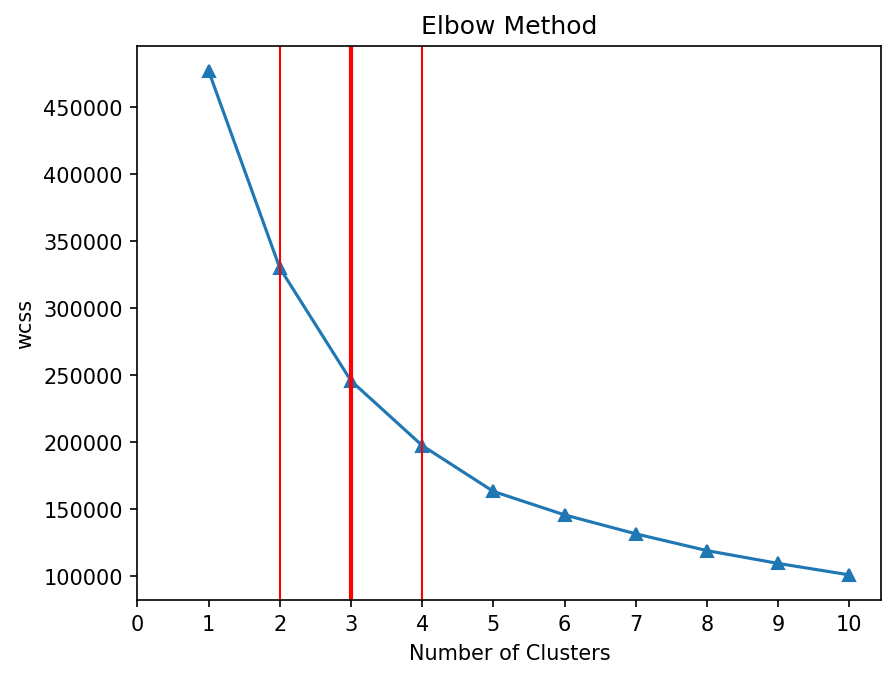

Number of Clusters: 2 , Silhouette score: 0.3434912551790813
Number of Clusters: 3 , Silhouette score: 0.3653225645294843
Number of Clusters: 4 , Silhouette score: 0.3312769660714327
Number of Clusters: 5 , Silhouette score: 0.3351341688591452
Number of Clusters: 6 , Silhouette score: 0.3308323889465946
Number of Clusters: 7 , Silhouette score: 0.2809713283917444
Number of Clusters: 8 , Silhouette score: 0.31048352087064723
Number of Clusters: 9 , Silhouette score: 0.3112216214351629
Number of Clusters: 10 , Silhouette score: 0.3123428819111878
Optimal number of components is: 3


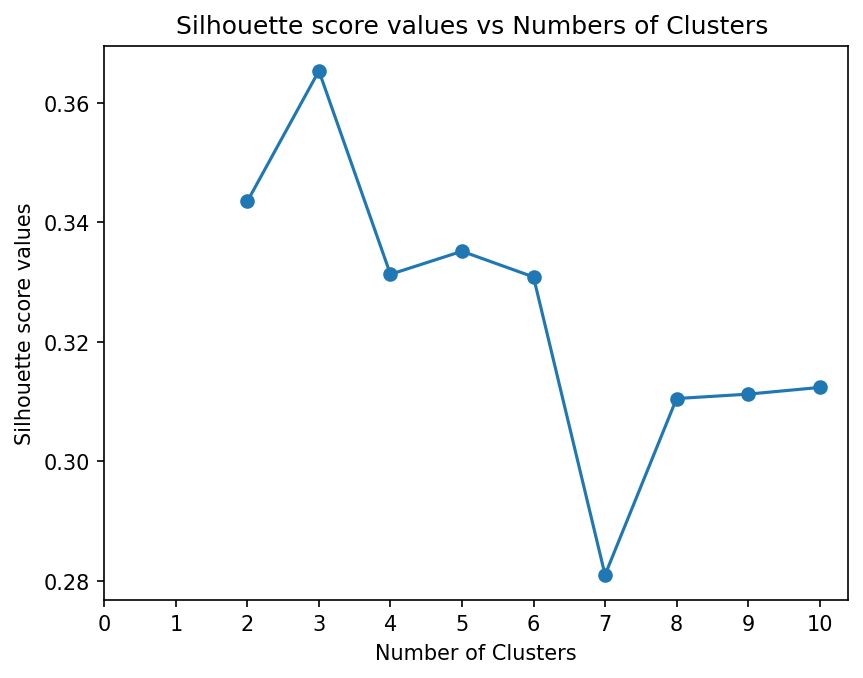

<Figure size 1500x1500 with 0 Axes>

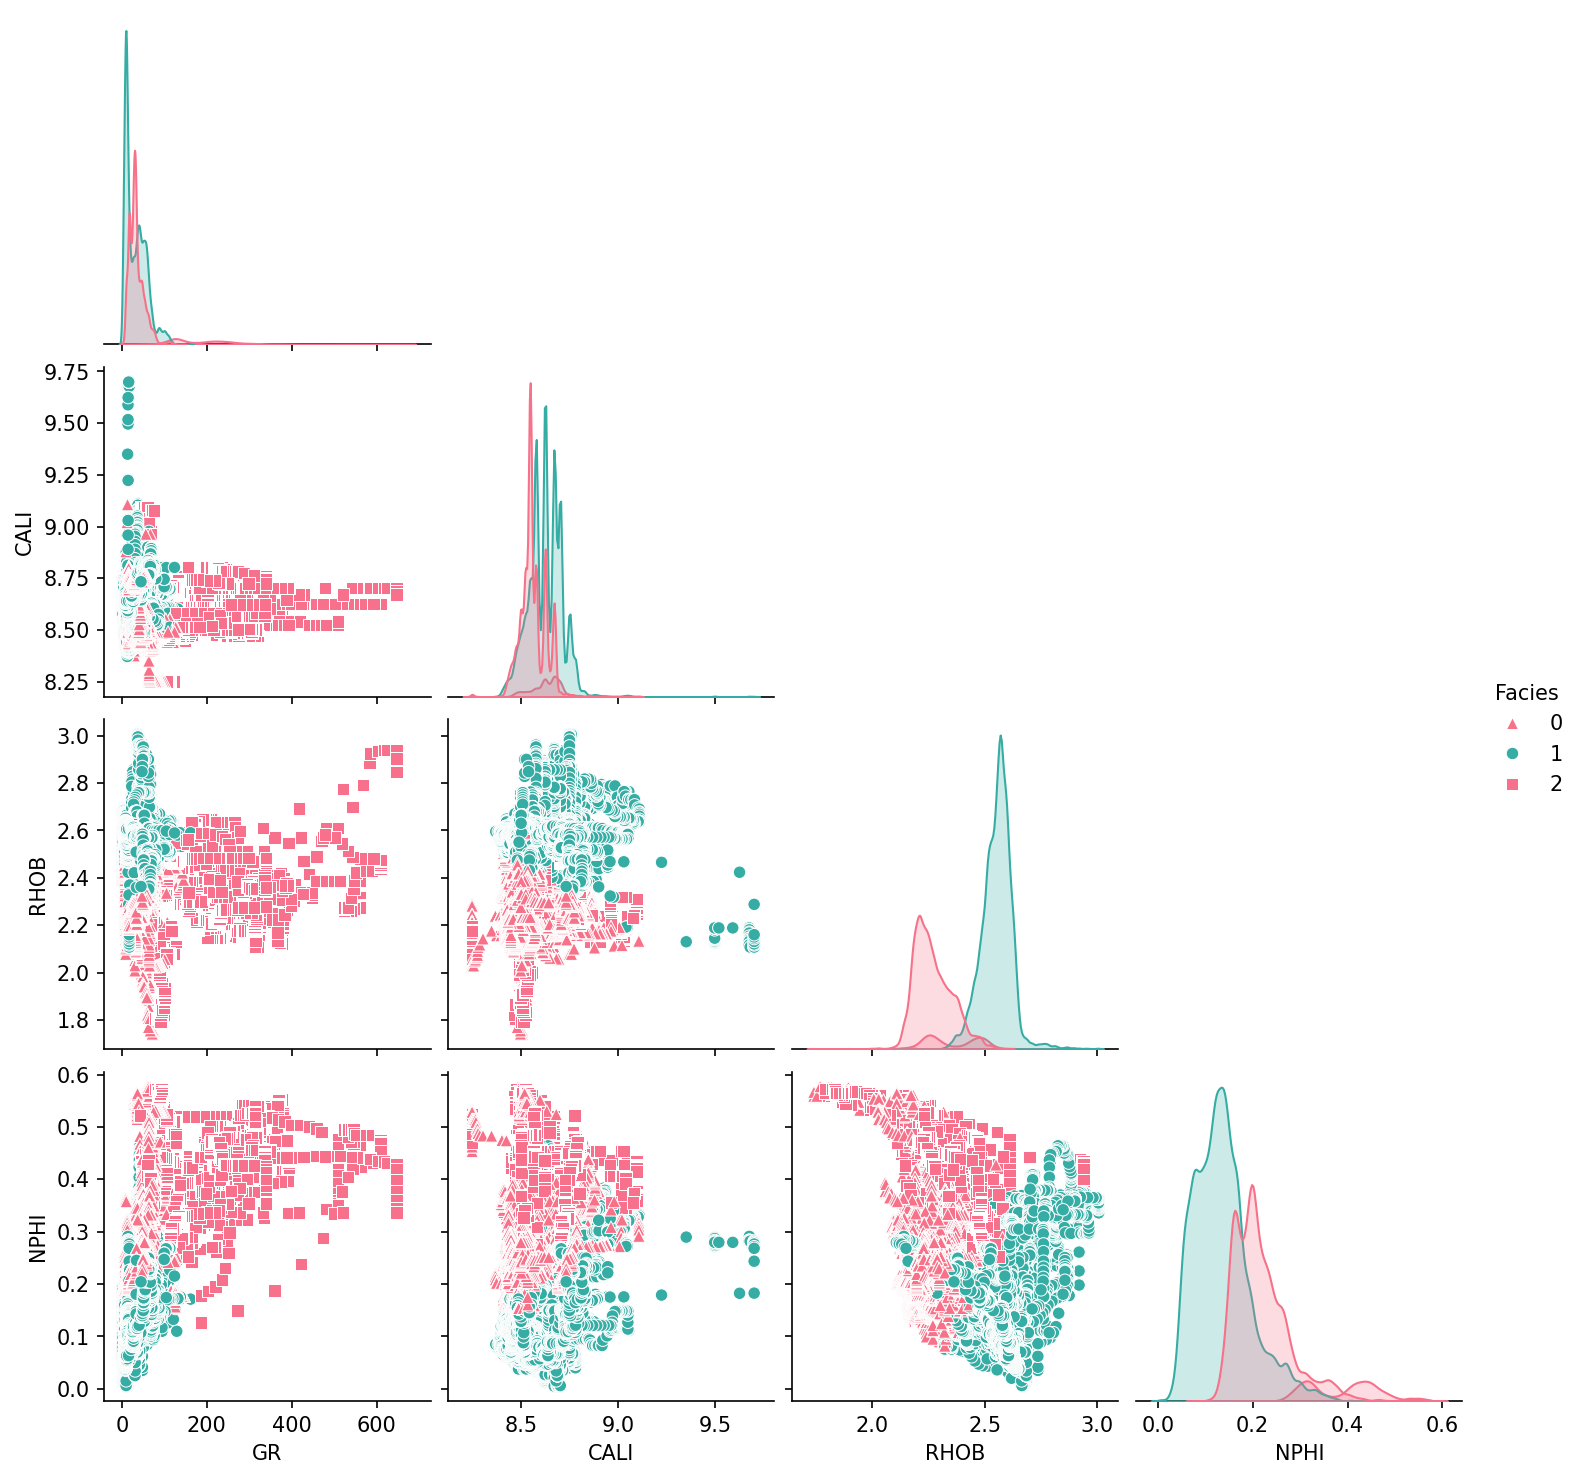

In [10]:
facies_group=['GR', 'CALI', 'RHOB', 'NPHI']#, 'BS', 'ROP', 'RM', 'RD'
dfm=dframe.dropna(subset=facies_group)
dfm[facies_group] = apply_filter(dfm[facies_group], name='All')
data_scaled = DataFrame(Prescale.fit_transform(dfm[facies_group]), 
                        index=dfm[facies_group].index,
                        columns=dfm[facies_group].columns)

df=data_cluster(data_scaled, name='Facies', ncomp=4, nclus=3)
dfm['Facies']=df['Facies']

plt.figure(figsize= (10,10))
ax=sns.pairplot(dfm, vars=facies_group, kind='scatter', diag_kind='kde', hue='Facies', 
                markers=['^','o','s'], palette='husl', height=2.5, corner=True)#, markers=['^','o','s','+','D']

## 预测部分

### VSHALE 预测



**1. 创建 VSHALE 预测数据集:**

* `VSHALE = dfm.drop([...], axis=1)`:
    * 从 `dfm` 数据帧中删除不需要的列，只保留用于预测 VSHALE 的列。
    * 被删除的列包括 'CALI', 'BS', 'ROP', 'RM', 'RD', 'PEF', ... 等。
* `print(VSHALE.info())`: 打印 `VSHALE` 数据帧的信息摘要，包括数据类型、非空值个数等。
* `VShale.dropna(inplace=True)`: 原地删除 `VSHALE` 数据帧中包含缺失值的样本。
* `VShale.shape`: 查看 `VSHALE` 数据帧的形状 (行数和列数)。

**2. 异常值处理:**

* `VShale_df = outlier_removal(VShale, ind=-2)`:
    * 调用名为 `outlier_removal` 的函数 (代码中未提供) 进行异常值处理。
    * 参数：
        * `VShale`: 需要处理的 DataFrame 对象。
        * `ind`: 似乎与处理方法有关，具体含义取决于函数本身的定义 (可能是索引或保留数据的列索引)。
    * 函数返回值被赋值给 `VShale_df` 变量，可能包含去除异常值后的数据。

**注意:**

* 代码中的一些函数和变量没有提供具体定义，需要结合上下文理解其含义和作用。
* 没有提供 `outlier_removal` 函数的具体实现，无法确定其处理异常值的方法。
* 建议根据需求选择合适的异常值处理方法，并查看处理后的数据的分布和统计量，确保数据质量。

<class 'pandas.core.frame.DataFrame'>
Index: 119180 entries, 36157 to 359567
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  119180 non-null  object 
 1   DEPTH      119180 non-null  float64
 2   GR         119180 non-null  float64
 3   RHOB       119180 non-null  float64
 4   NPHI       119180 non-null  float64
 5   VSH        69705 non-null   float64
 6   Facies     119180 non-null  int32  
dtypes: float64(5), int32(1), object(1)
memory usage: 6.8+ MB
None
Before anomaly treatment
                  GR          RHOB          NPHI           VSH        Facies
count  69705.000000  69705.000000  69705.000000  69705.000000  69705.000000
mean      43.359129      2.408598      0.186832      0.304147      0.553906
std       37.800603      0.157124      0.069605      0.222815      0.553150
min        5.494200      2.057700      0.005000      0.000000      0.000000
25%       20.886200      2.260900      0.146700  

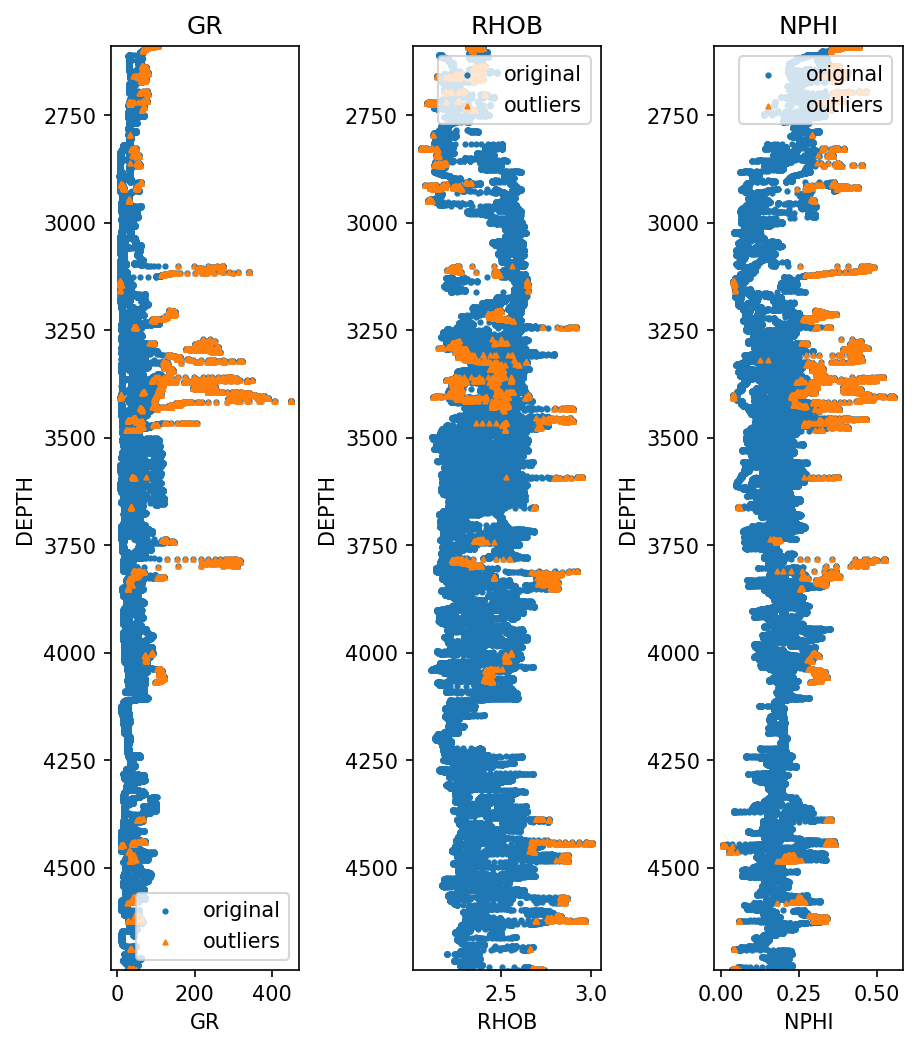

In [17]:
#%% Create DataFrame for each target value - Machine learning
#%% `Create`创建`DataFrame`数据框`for each target value`目标值`- Machine learning`
VShale = dfm.drop(['CALI', 'BS', 'ROP', 'RM', 'RD', 'PEF', 'DT', 'DTS', 'VCARB', 'PHIF', 'SW',#
                      'KLOGH', 'SAND_FLAG', 'CARB_FLAG', 'COAL_FLAG'], axis=1)
print(VShale.info())
# drop all nan values from VShale data
# 从`VShale`数据中`drop`删除所有`nan`值
VShale.dropna(inplace=True)
VShale.shape

VShale_df=outlier_removal(VShale, ind=-2)

#### 可视化

相关性和热力图

**1. 准备数据:**

* `data_scaled = DataFrame(Prescale.fit_transform(VShale_df.drop(['WELL_NAME', 'DEPTH'], axis = 1)), ...)`:
    * 从 `VShale_df` 数据帧中去除 'WELL_NAME' 和 'DEPTH' 列，只保留用于计算相关性的特征。
    * 使用 `Prescale` 管道对选定的特征进行标准化 (fit_transform)。
    * 将标准化后的数据转换为 DataFrame 对象 `data_scaled`。

**2. 计算相关系数矩阵:**

* `data_scaled.corr(method='pearson')`: 计算 `data_scaled` 数据帧中各个特征之间的 Pearson 相关系数矩阵。

**3. 绘制相关热图:**

* `plt.figure(figsize= (10,10))`: 创建一个大小为 10 x 10 的 Matplotlib 图形。
* `ax = sns.heatmap(...)`: 使用 Seaborn 库的 `heatmap` 函数创建相关热图。
    * 参数：
        * `data_scaled.corr(method='pearson')`: 计算好的相关系数矩阵。
        * `annot=True`: 在热图中显示相关系数数值。
        * `fmt ='.0%'`: 格式化显示的数值 (保留两位小数并添加百分号)。
        * `cmap="Spectral_r"`: 使用 "Spectral_r" 颜色映射。
        * `square=True`: 使得热图呈正方形。
* `plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")`: 设置 x 轴刻度标签的旋转角度 (45 度) 和对齐方式 (右对齐)。
* `plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")`: 设置 y 轴刻度标签的旋转角度 (0 度) 和对齐方式 (右对齐)。
* `ax.set_title('VShale correlation',weight='bold', fontsize=24)`: 设置热图的标题 (VShale 相关性)、字体样式 (粗体) 和大小 (24)。

**总结:**

这段代码计算了 VSHALE 预测模型中各个特征之间的相关系数，并使用 Seaborn 库绘制了相关热图。该热图可以帮助您直观地观察特征之间的相关性强弱，并判断是否存在冗余特征。


Text(0.5, 1.0, 'VShale correlation')

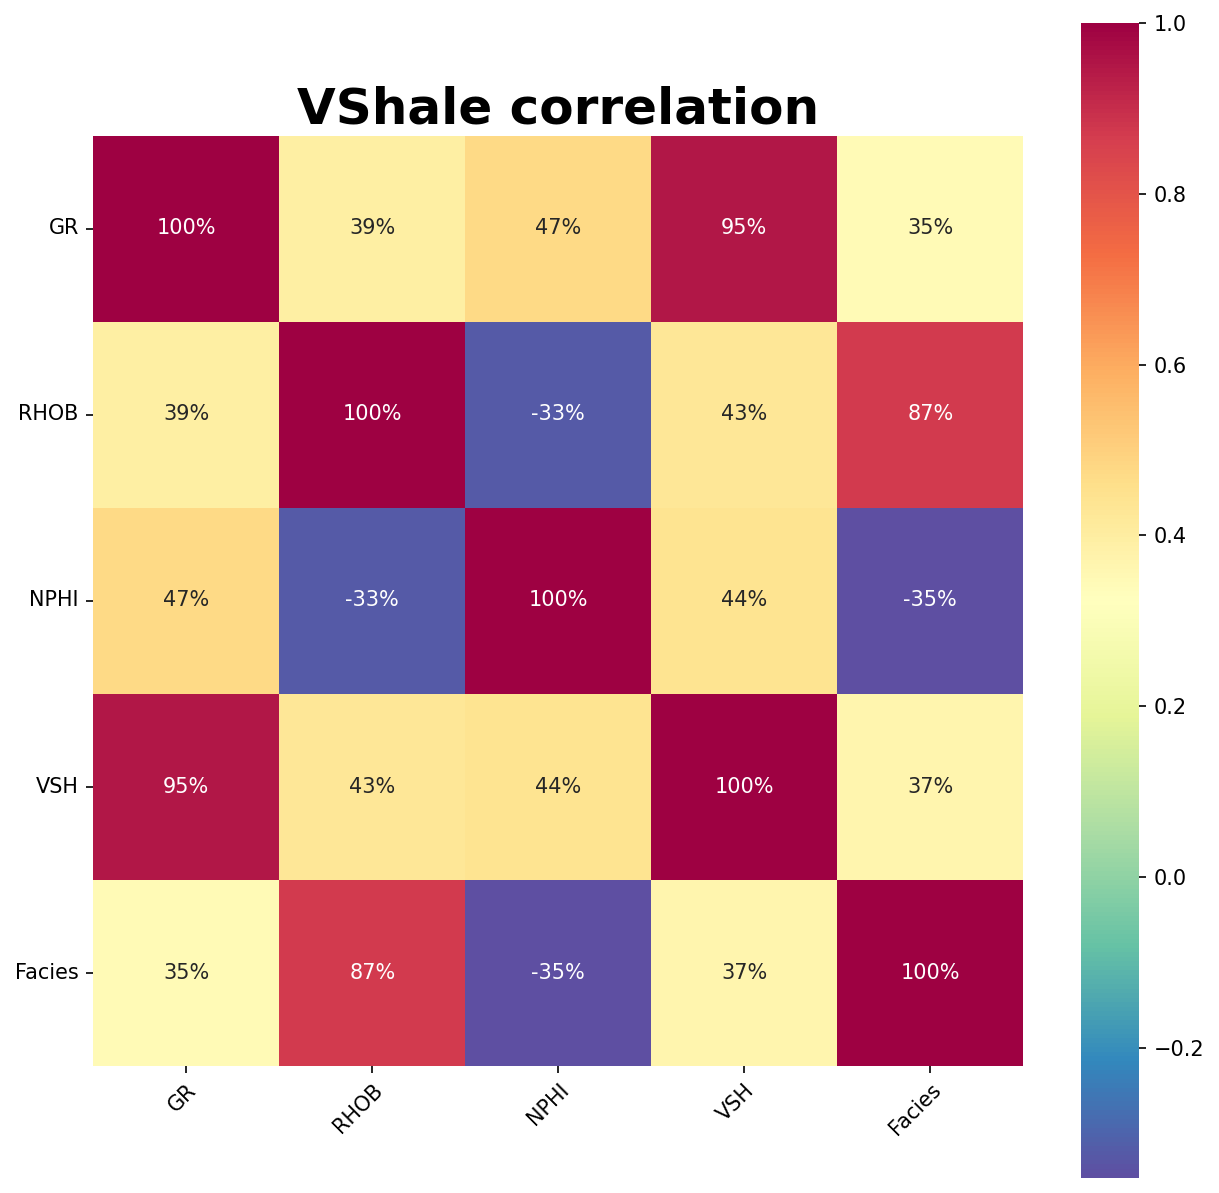

In [18]:
# Visualize correlation
# `Visualize`可视化`correlation`相关性
data_scaled = DataFrame(Prescale.fit_transform(VShale_df.drop(['WELL_NAME', 'DEPTH'], axis = 1)), 
                        index=VShale_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).index,
                        columns=VShale_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).columns)
plt.figure(figsize= (10,10))
# Draw a heatmap
# 绘制`heatmap`热图
ax=sns.heatmap(data_scaled.corr(method='pearson'), annot=True, fmt ='.0%', cmap="Spectral_r", square=True)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
ax.set_title('VShale correlation',weight='bold', fontsize=24)



**1. 统计分析:**

* `well_stat = VShale_df.groupby(['WELL_NAME']).describe()`:
    * 基于 `WELL_NAME` 列对 `VShale_df` 数据帧进行分组。
    * 对每个分组 (井) 的特征值进行描述性统计，得到 `well_stat` 数据帧。
* `print(well_stat)`: 打印每个井的特征值的描述性统计信息，例如均值、标准差、最小值、最大值等。

**2. 划分测试集和训练集:**

* `VShale_blind = VShale_df[VShale_df['WELL_NAME'] == 'Well_F11A']`:
    * 筛选出 `WELL_NAME` 为 'Well_F11A' 的样本，将其作为测试集 (VShale_blind)。
* `VShale = VShale_df[VShale_df['WELL_NAME'] != 'Well_F11A']`:
    * 筛选出 **不是** 'Well_F11A' 的样本，将其作为训练集 (VShale)。

**3. 可视化聚类结果:**

* `log_plot (VShale_blind, name='Facies', ycbar=10, title='Log display with Facies for Test')`:
    * 调用 `log_plot` 函数 (之前已解释) 绘制测试集 (VShale_blind) 的测井曲线和地层 (Facies) 的组合图。
    * 参数：
        * `VShale_blind`: 测试集数据。
        * `name`: 地层列名 ('Facies')。
        * `ycbar`: 控制颜色条中每个标签的垂直位置偏移 (10)。
        * `title`: 图形标题 ('Log display with Facies for Test')。
* `log_plot (VShale[VShale['WELL_NAME'] == 'Well_F1C'], name='Facies', ycbar=10, ...)`:
    * 同样使用 `log_plot` 函数绘制训练集中一个特定的井 (Well_F1C) 的测井曲线和地层 (Facies) 的组合图。
    * 其他参数与测试集的绘制相同。

**总结:**

这段代码首先对每个井的特征值进行统计分析，然后将数据分为测试集和训练集。最后，分别绘制测试集和训练集中特定井的测井曲线和地层 (Facies) 的组合图，可以直观地观察地层分布和数据特性。

              DEPTH                                                            \
              count         mean         std        min        25%        50%   
WELL_NAME                                                                       
Well_F1      2861.0  3463.686473   82.627539  3319.8000  3392.2000  3463.7000   
Well_F11A    1566.0  3656.816667   46.683351  3575.0000  3616.8250  3655.9500   
Well_F11B   13374.0  4051.776320  401.285071  3351.6000  3697.4250  4059.2500   
Well_F11T2   1951.0  4435.503947   58.916379  4334.7000  4383.4500  4434.1000   
Well_F15     6268.0  3132.139461  291.197035  2599.9440  2885.1987  3138.9066   
Well_F15A    9450.0  3343.278677  423.325511  2608.6308  2979.1533  3340.3794   
Well_F15B    1311.0  3381.065492   60.642332  3277.3620  3327.2730  3384.0420   
Well_F15C    1804.0  3066.406777   88.432808  2921.2032  2989.8975  3058.5918   
Well_F15D   11691.0  4057.550594  339.173993  3466.7000  3763.9500  4057.7000   
Well_F1A     2253.0  3544.67

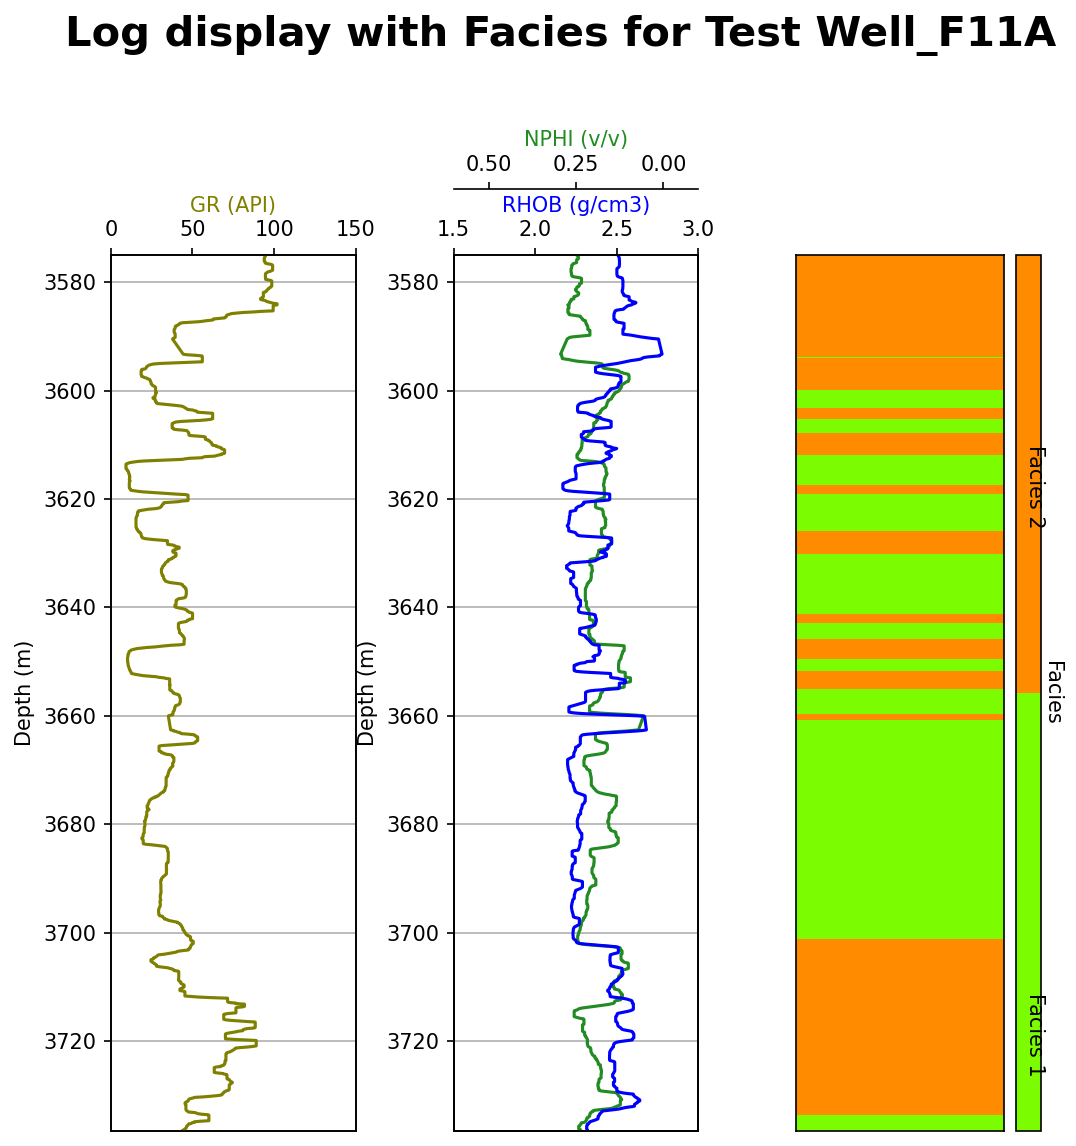

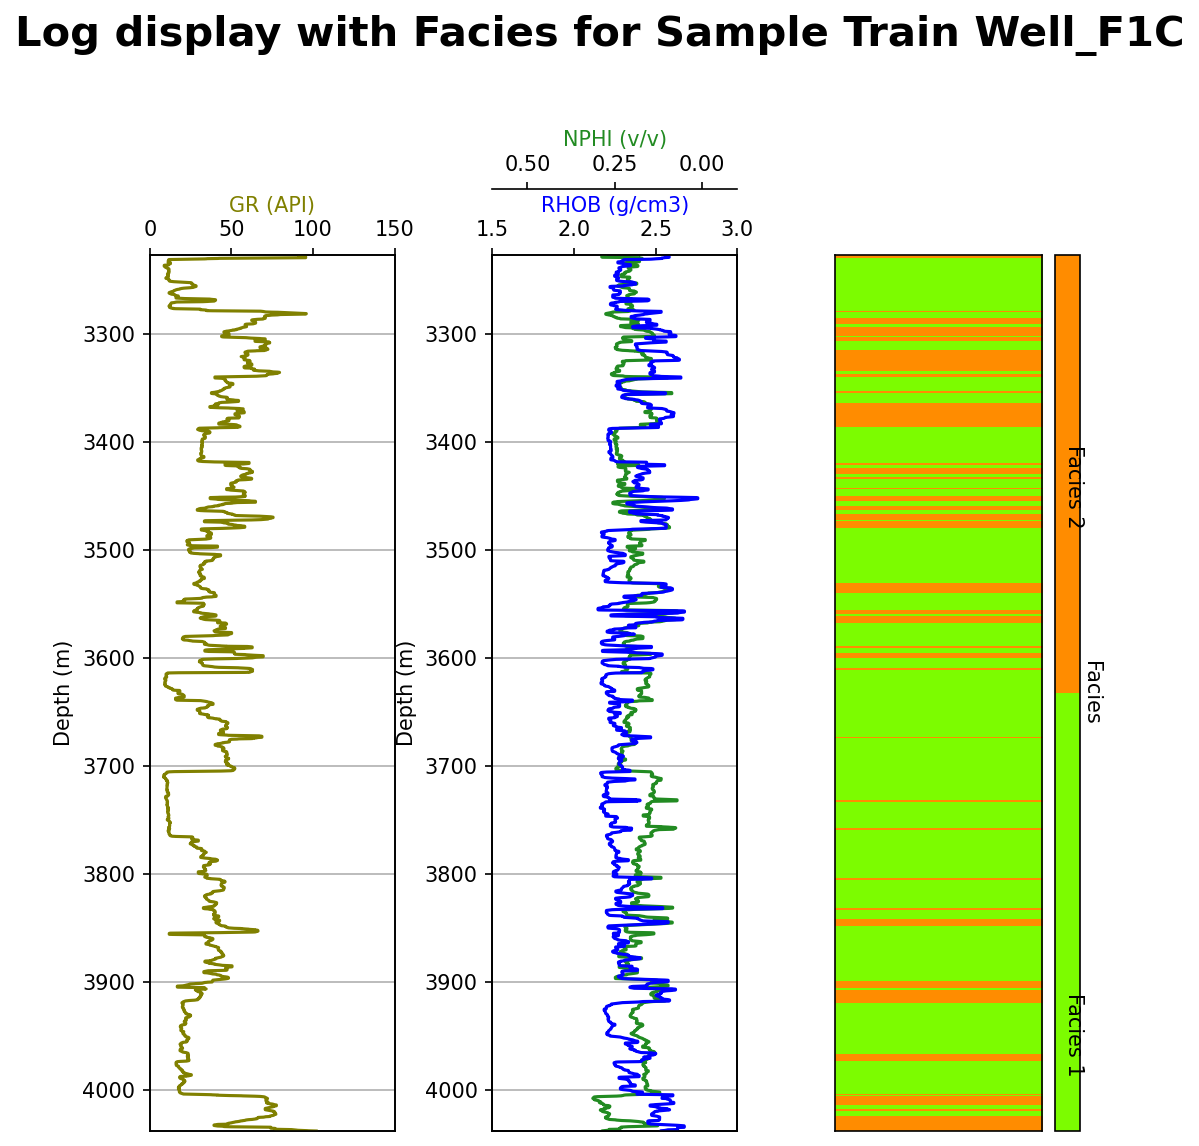

In [19]:
# check out statistics by well 
# 按`well`井`check out`检查`statistics`统计
well_stat=VShale_df.groupby(['WELL_NAME']).describe()
print(well_stat)
# create blind test data with Well_F11A
# 创建`blind test`盲测试数据`with Well_F11A`
VShale_blind = VShale_df[VShale_df['WELL_NAME'] == 'Well_F11A']
VShale = VShale_df[VShale_df['WELL_NAME'] != 'Well_F11A']

# Visualising the zone clusters
# 可视化`zone clusters`区域聚类`clusters`
log_plot (VShale_blind, name='Facies', ycbar=10, title='Log display with Facies for Test')
log_plot (VShale[VShale['WELL_NAME'] == 'Well_F1C'], name='Facies', ycbar=10,
          title='Log display with Facies for Sample Train')

#### 测试

**1. 循环遍历地层进行预测:**

* `Y_pred_VShale=np.zeros(VShale_blind.shape[0])`: 创建一个空数组 `Y_pred_VShale` 用于存储最终的预测值，其长度等于测试集的样本数量。
* 循环遍历 `VShale` 数据帧中 `Facies` 列的唯一值 (地层类型)：
    * 筛选出属于当前地层的样本，并复制一份数据 (`VShale_split`)。
    * 从 `VShale_split` 中提取目标变量 (VSH) 和属性 (其他特征)，并进行必要的处理：
        * `target` 提取 'DEPTH' 和 'VSH' 列，并设置索引为 'DEPTH'。
        * `attributes` 剔除 'WELL_NAME', 'DEPTH', 'VSH', 'Facies' 列，并应用 `apply_filter` 函数 (未提供定义) 进行预处理。
    * 调用 `model_predict` 函数 (之前已解释) 训练模型并进行预测：
        * 参数：
            * `attributes`: 经过预处理的属性数据。
            * `target`: 目标变量 (VSH)。
            * `'Facies %s' % str(i+1)`: 用于区分不同地层的模型名称。
            * `name`: 地层名称 (VSHale)。
        * 函数返回训练好的模型 (`model`)、预处理管道 (`Prescale`) 和网格搜索结果 (`results`)。
        * 打印模型的最佳超参数 (`model.best_params_`)。
    * **测试集预测:**
        * 筛选出测试集中属于当前地层的样本 (`VShale_blind_split`)。
        * 提取测试集中的目标变量 (VSH) 和属性，并进行处理：
            * `Y_blind` 提取 'DEPTH' 和 'VSH' 列，并设置索引为 'DEPTH'。
            * `X_blind` 剔除 'WELL_NAME', 'DEPTH', 'VSH', 'Facies' 列，并应用 `apply_filter` 函数 (未提供定义) 进行预处理。
        * 使用训练好的模型 (`model`) 和预处理管道 (`Prescale`) 对测试集进行预测，并将结果保存到 `Y_blind_pred` 数组中。
    * 将 `Y_blind_pred` 预测值根据地层类别对应地保存到 `Y_pred_VShale` 数组中。

**2. 获取真实值:**

* `Y_test_VShale=VShale_blind.VSH.values`: 从测试集中提取真实的 VSH 值并转换为数组 `Y_test_VShale`。

**总结:**

这段代码循环遍历每个地层，使用训练集中的数据训练模型，并用该模型来预测测试集中对应地层的 VSH 值。最后，将所有地层的预测值合并到 `Y_pred_VShale` 数组中，并获取测试集的真实 VSH 值 `Y_test_VShale`。

Before applying noise-filter [VShale]
                  GR          RHOB          NPHI
count  31233.000000  31233.000000  31233.000000
mean      30.015463      2.270543      0.196526
std       14.440503      0.079547      0.038794
min        5.862900      2.113800      0.081700
25%       18.172000      2.207000      0.166000
50%       28.268900      2.258000      0.193600
75%       38.290001      2.324200      0.217000
max       97.970398      2.565000      0.371820
After applying noise-filter [VShale]
                  GR          RHOB          NPHI
count  31233.000000  31233.000000  31233.000000
mean      30.088997      2.270772      0.197293
std       14.368014      0.078115      0.038373
min        5.961700      2.115000      0.113300
25%       18.227000      2.207800      0.166200
50%       28.422200      2.259800      0.194500
75%       38.318100      2.324000      0.217900
max       97.333298      2.521000      0.369397


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             refit='r2', scoring=['neg_mean_squared_error', 'r2'])
Best: 0.839199 using {'C': 1.0, 'gamma': 0.025118864315095808}
         means     stdev                                       params
rank                                                                 
1     0.839199  0.015022    {'C': 1.0, 'gamma': 0.025118864315095808}
2     0.838327  0.012626      {'C': 1.0, 'gamma': 0.6309573444801936}
3     0.836875  0.014205  {'C': 100.0, 'gamma': 0.025118864315095808}
4     0.836832  0.012201     {'C': 10.0, 'gamma': 0.6309573444801936}
5     0.835412  0.014184   {'C': 10.0, 'gamma': 0.025118864315095808}
6     0.832295  0.012288    {'C': 100.0, 'gamma': 0.6309573444801936}
7     0.824117  0.015627                 {'C': 100.0, 'gamma': 0.001}
8     0.820868  0.013977              

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'C': 100.0, 'gamma': 0.6309573444801936}
Before applying noise-filter [VShale]
               GR        RHOB        NPHI
count  768.00000  768.000000  768.000000
mean    55.35247    2.494652    0.183911
std     25.01132    0.071290    0.054716
min     10.14200    2.336000    0.057000
25%     37.50800    2.457000    0.127000
50%     47.98000    2.488000    0.186000
75%     72.53300    2.535000    0.231250
max    101.85200    2.778000    0.294000
After applying noise-filter [VShale]
                GR        RHOB        NPHI
count  768.000000  768.000000  768.000000
mean    55.820380    2.496618    0.184694
std     24.683654    0.064027    0.054008
min     10.402000    2.364000    0.099000
25%     38.853000    2.457000    0.126000
50%     47.503000    2.494500    0.186000
75%     72.533000    2.533000    0.233000
max     99.438000    2.669000    0.280000


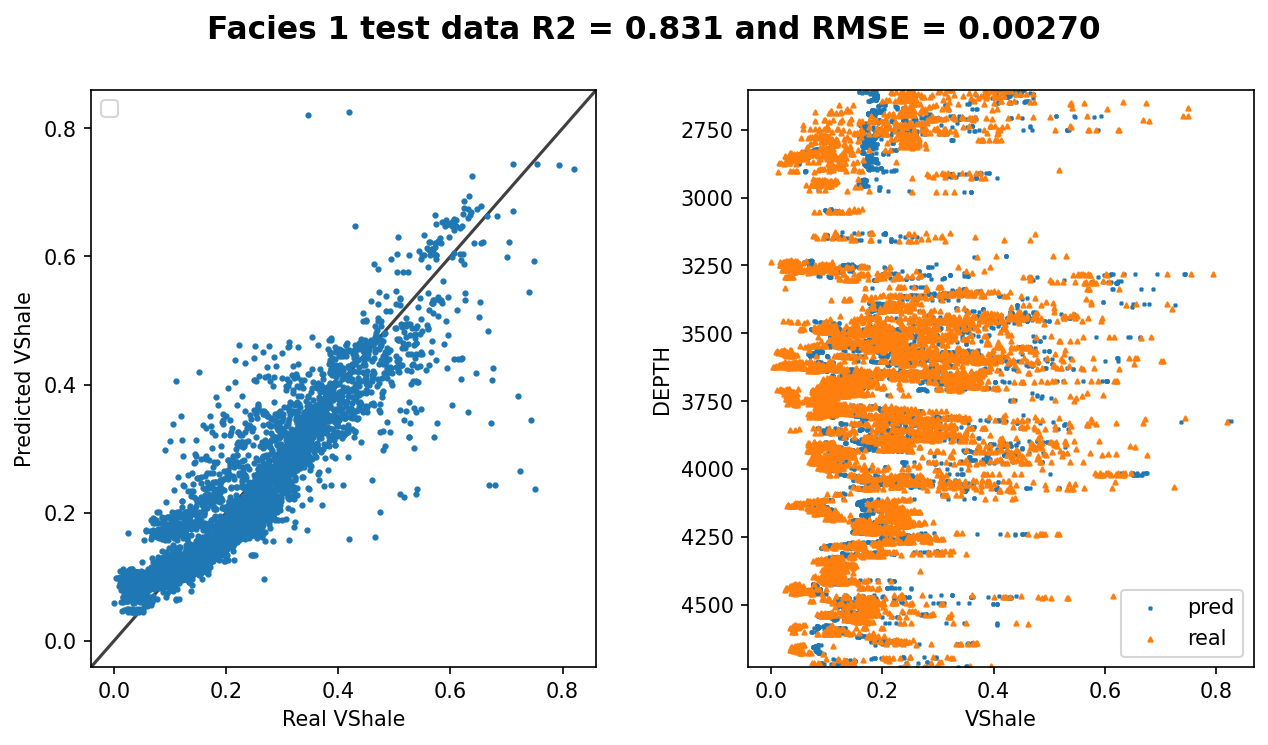

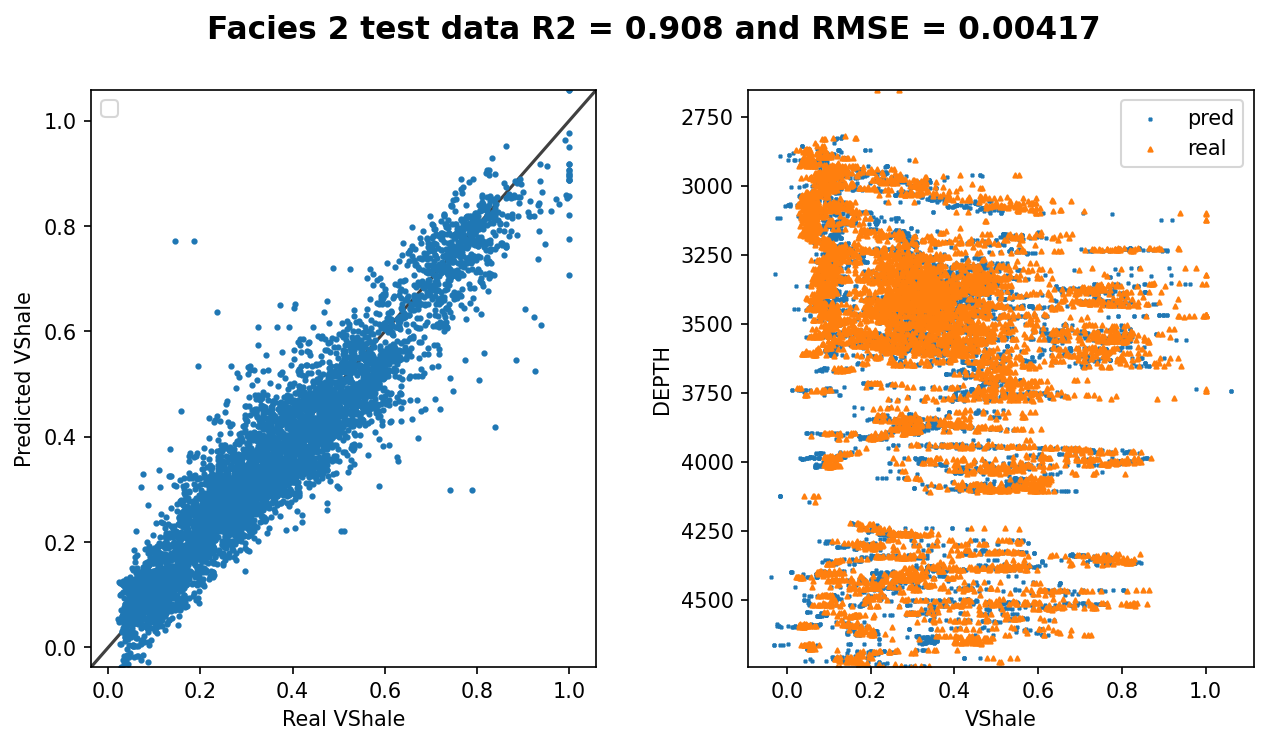

In [20]:
# Split dataset into target and attributes
# `Split`划分数据集为`target`目标和`attributes`属性
Y_pred_VShale=np.zeros(VShale_blind.shape[0])# array for saving predictions # 用于保存预测的数组
name='VShale'
for i in VShale['Facies'].unique():
    VShale_split=VShale[VShale.Facies.values==i].copy()
    target = VShale_split[['DEPTH', 'VSH']]
    target.set_index('DEPTH', inplace=True)
    attributes = VShale_split.drop(['WELL_NAME', 'DEPTH', 'VSH', 'Facies'], axis = 1)
    attributes = apply_filter(attributes, name=name)
    
    model, Prescale, results = model_predict(attributes,target,'Facies %s' % str(i+1), name=name)
    print(model.best_params_)
    
    #BLIND WELL TEST
    # 测试`blind well`盲井
    VShale_blind_split=VShale_blind[VShale_blind.Facies.values==i].copy()
    Y_blind = VShale_blind_split[['DEPTH', 'VSH']]
    Y_blind.set_index('DEPTH', inplace=True)
    X_blind = VShale_blind_split.drop(['WELL_NAME', 'DEPTH', 'VSH', 'Facies'], axis = 1)
    X_blind = apply_filter(X_blind, name=name)
    

    # save the prediction
    # 保存预测
    Y_blind_pred = model.predict(Prescale.transform(X_blind))
    Y_pred_VShale[VShale_blind.Facies.values==i]=Y_blind_pred
    
Y_test_VShale=VShale_blind.VSH.values

#### 模型评估


**1. 评估模型性能:**

* `mse = mean_squared_error(Y_test_VShale, Y_pred_VShale)`: 计算测试集真实 VSH 值 (`Y_test_VShale`) 和预测值 (`Y_pred_VShale`) 之间的均方误差 (MSE)。
* `r2 = r2_score(Y_test_VShale, Y_pred_VShale)`: 计算测试集真实 VSH 值 (`Y_test_VShale`) 和预测值 (`Y_pred_VShale`) 之间的 R 方值 (R2)。

**2. 可视化预测结果:**

* `plt.plot(Y_test_VShale, VShale_blind.DEPTH, c='cyan')`: 
    * 使用蓝色 ('cyan') 线段图绘制测试集的真实 VSH 值 (`Y_test_VShale`) 随深度 (VShale_blind.DEPTH) 的变化趋势。
* `plt.plot(Y_pred_VShale, VShale_blind.DEPTH, c='darkslategrey', linestyle='-.')`:
    * 使用深灰色 ('darkslategrey') 虚线图 ('-.') 绘制测试集的预测 VSH 值 (`Y_pred_VShale`) 随深度 (VShale_blind.DEPTH) 的变化趋势。
* 设置网格 (plt.grid())、坐标轴标签、坐标轴范围、图例、以及标题。
* 标题中包含 R2 值 (格式化成三位小数) 和 MSE 值 (格式化成五位小数)。

**总结:**

这段代码计算了模型的均方误差 (MSE) 和 R 方值 (R2) 来评估模型的预测性能，并利用 Matplotlib 绘制了测试集真实 VSH 值和预测 VSH 值随深度的变化曲线，直观地展示了模型的预测结果。

Text(0.5, 1.0, 'R2 = 0.886 and RMSE = 0.00627')

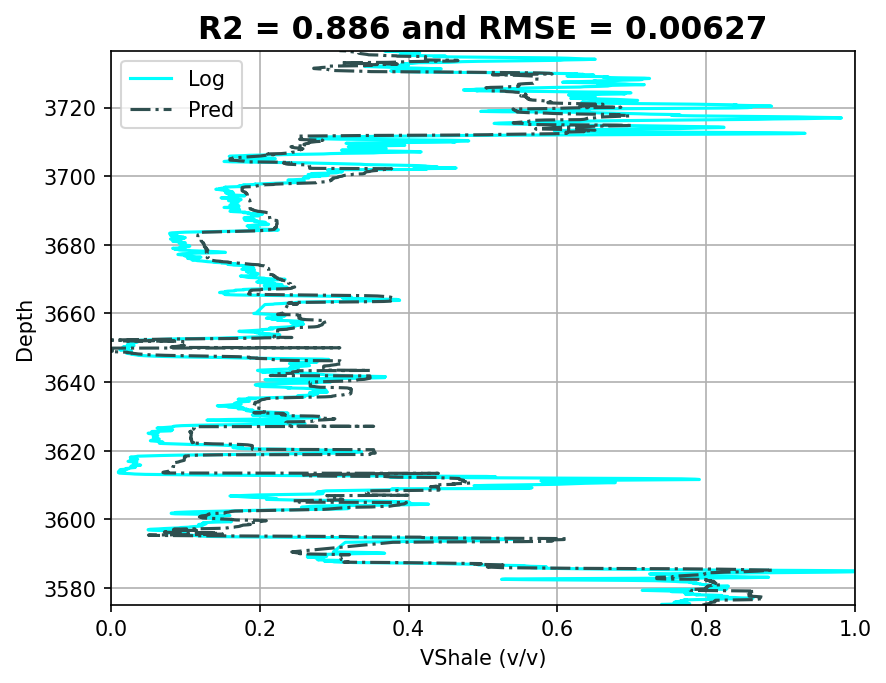

In [21]:
#test the accuracy
# 测试准确性
mse = mean_squared_error(Y_test_VShale, Y_pred_VShale)
r2 = r2_score(Y_test_VShale, Y_pred_VShale)

plt.plot(Y_test_VShale, VShale_blind.DEPTH, c='cyan')
plt.plot(Y_pred_VShale, VShale_blind.DEPTH, c='darkslategrey', linestyle='-.')
plt.grid()
plt.xlabel('VShale (v/v)')
plt.xlim(0,1) 
plt.ylim(np.min(VShale_blind.DEPTH),np.max(VShale_blind.DEPTH)) 
plt.ylabel('Depth')
plt.legend(['Log', 'Pred'], loc=0)
plt.title('R2 = {:.3f} and RMSE = {:.5f}'.format(r2, mse), weight='bold', fontsize=15)

### DT Prediction

<class 'pandas.core.frame.DataFrame'>
Index: 119180 entries, 36157 to 359567
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  119180 non-null  object 
 1   DEPTH      119180 non-null  float64
 2   GR         119180 non-null  float64
 3   CALI       119180 non-null  float64
 4   RHOB       119180 non-null  float64
 5   NPHI       119180 non-null  float64
 6   DT         77991 non-null   float64
 7   Facies     119180 non-null  int32  
dtypes: float64(6), int32(1), object(1)
memory usage: 7.7+ MB
None
Before anomaly treatment
                  GR          CALI          RHOB          NPHI            DT  \
count  77991.000000  77991.000000  77991.000000  77991.000000  77991.000000   
mean      40.617741      8.611021      2.474543      0.168193     77.186891   
std       49.550348      0.090364      0.140250      0.093305     14.433990   
min        1.553500      8.371600      2.057700      0.005000     48.275

Method =  2 :  Isolation Forest

Number of anomalies detected for GR = 4658 out of 77991

Number of anomalies detected for CALI = 4673 out of 77991

Number of anomalies detected for RHOB = 4637 out of 77991

Number of anomalies detected for NPHI = 4680 out of 77991

Number of dataset after anomalies removal = 63314
After anomaly treatment
                  GR          CALI          RHOB          NPHI            DT  \
count  63314.000000  63314.000000  63314.000000  63314.000000  63314.000000   
mean      30.273953      8.609984      2.496615      0.145767     74.090811   
std       23.300113      0.075566      0.119803      0.066738     11.137100   
min        1.553500      8.449700      2.188900      0.042800     49.543098   
25%       10.188175      8.547000      2.463925      0.095000     66.357853   
50%       26.929000      8.625000      2.538100      0.135000     71.644000   
75%       45.410075      8.672000      2.579700      0.182800     79.672800   
max      115.940002      8

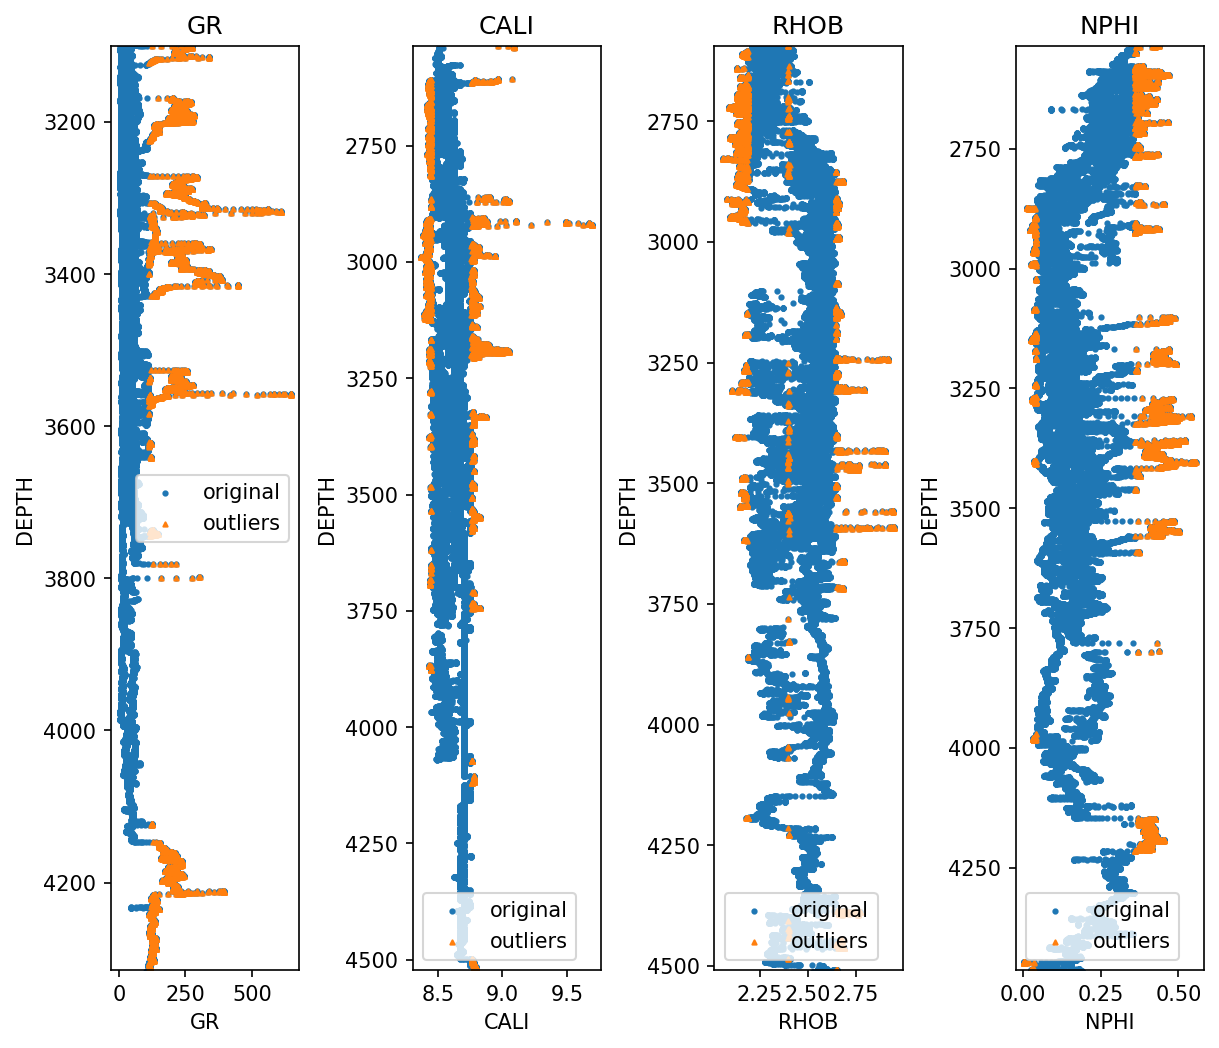

In [23]:
DT = dfm.drop(['BS', 'ROP', 'RM', 'RD', 'DTS', 'VCARB', 'VSH', 'PHIF', 'SW', 'PEF',
                  'KLOGH', 'SAND_FLAG', 'CARB_FLAG', 'COAL_FLAG'], axis=1) 
print(DT.info())
# drop all nan values from VShale data
DT.dropna(inplace=True)
DT.shape

DT_df=outlier_removal(DT, ind=-2)

Text(0.5, 1.0, 'DT correlation')

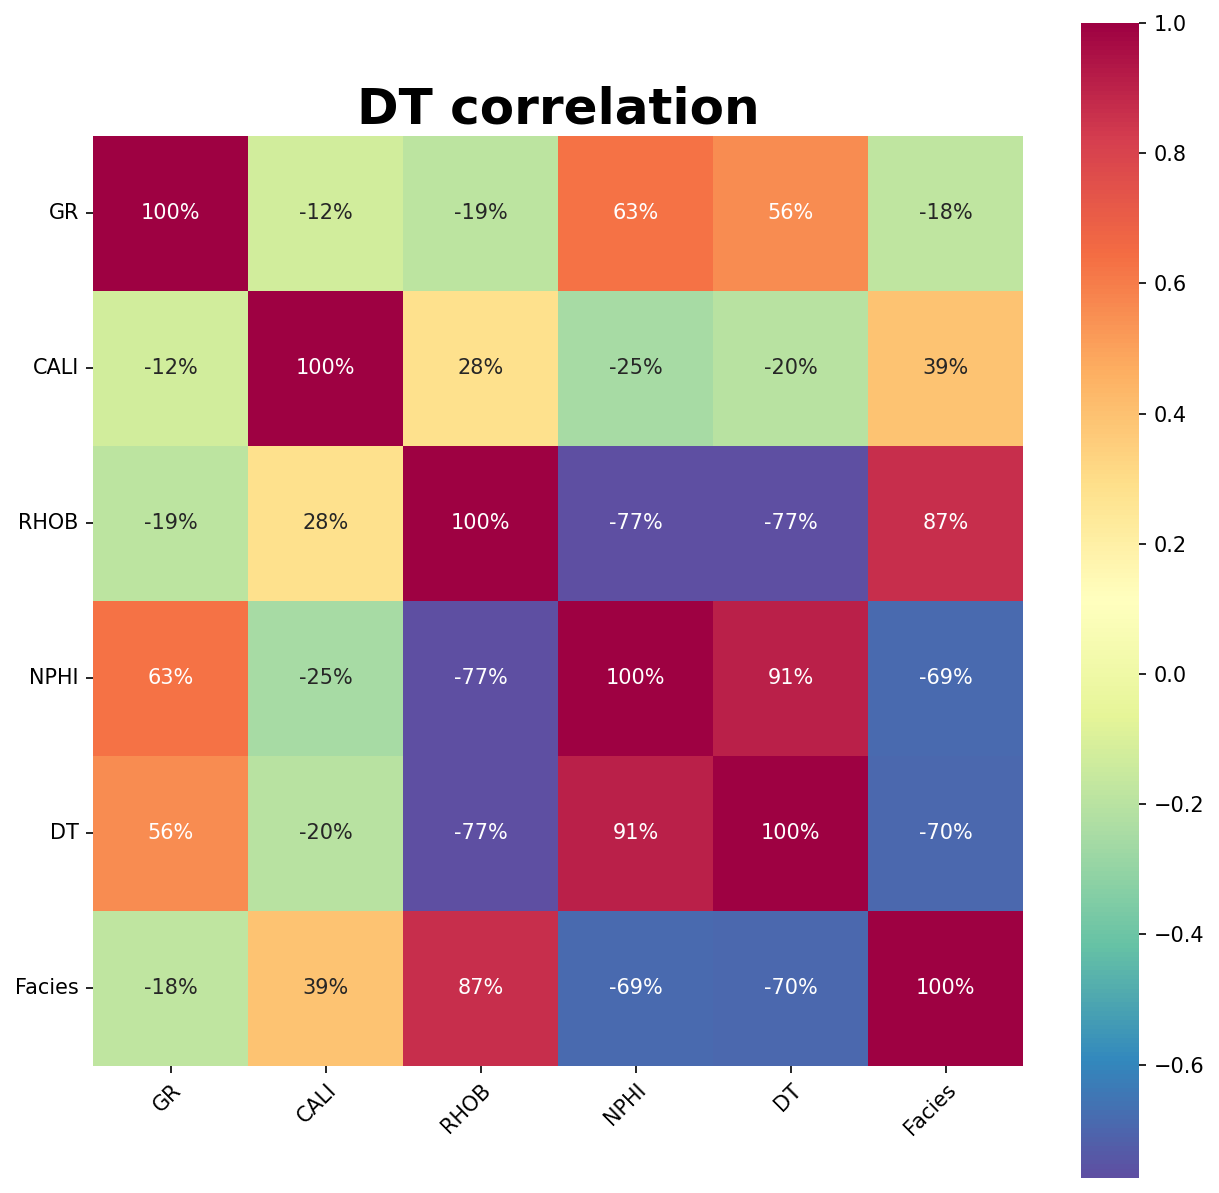

In [24]:
# Visualize correlation
data_scaled = DataFrame(Prescale.fit_transform(DT_df.drop(['WELL_NAME', 'DEPTH'], axis = 1)), 
                        index=DT_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).index,
                        columns=DT_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).columns)
plt.figure(figsize= (10,10))
# Draw a heatmap
ax=sns.heatmap(data_scaled.corr(method='pearson'), annot=True, fmt ='.0%', cmap="Spectral_r", square=True)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
ax.set_title('DT correlation',weight='bold', fontsize=24)

              DEPTH                                                            \
              count         mean         std        min        25%        50%   
WELL_NAME                                                                       
Well_F1      8992.0  3104.936299  283.957510  2618.1000  2862.9750  3092.5500   
Well_F11A    9912.0  3170.999173  311.247886  2577.0000  2922.8750  3171.9500   
Well_F11T2  15014.0  3529.252851  529.568293  2577.0000  3071.3250  3528.6500   
Well_F15     5584.0  3146.586343  313.658661  2539.2888  2900.1339  3191.7894   
Well_F15A    6909.0  3482.260877  370.684303  2616.2508  3243.0720  3509.1624   
Well_F15B    1770.0  3327.388635   83.462920  3174.9492  3256.3689  3323.7678   
Well_F15C    1052.0  3026.332400   78.452067  2910.0780  2961.7035  3005.5566   
Well_F1A     8950.0  3115.390838  291.330917  2619.8000  2868.2250  3103.5500   
Well_F1B     2554.0  3275.324002  100.467174  3098.5000  3162.3250  3291.7500   
Well_F5      2577.0  3532.13

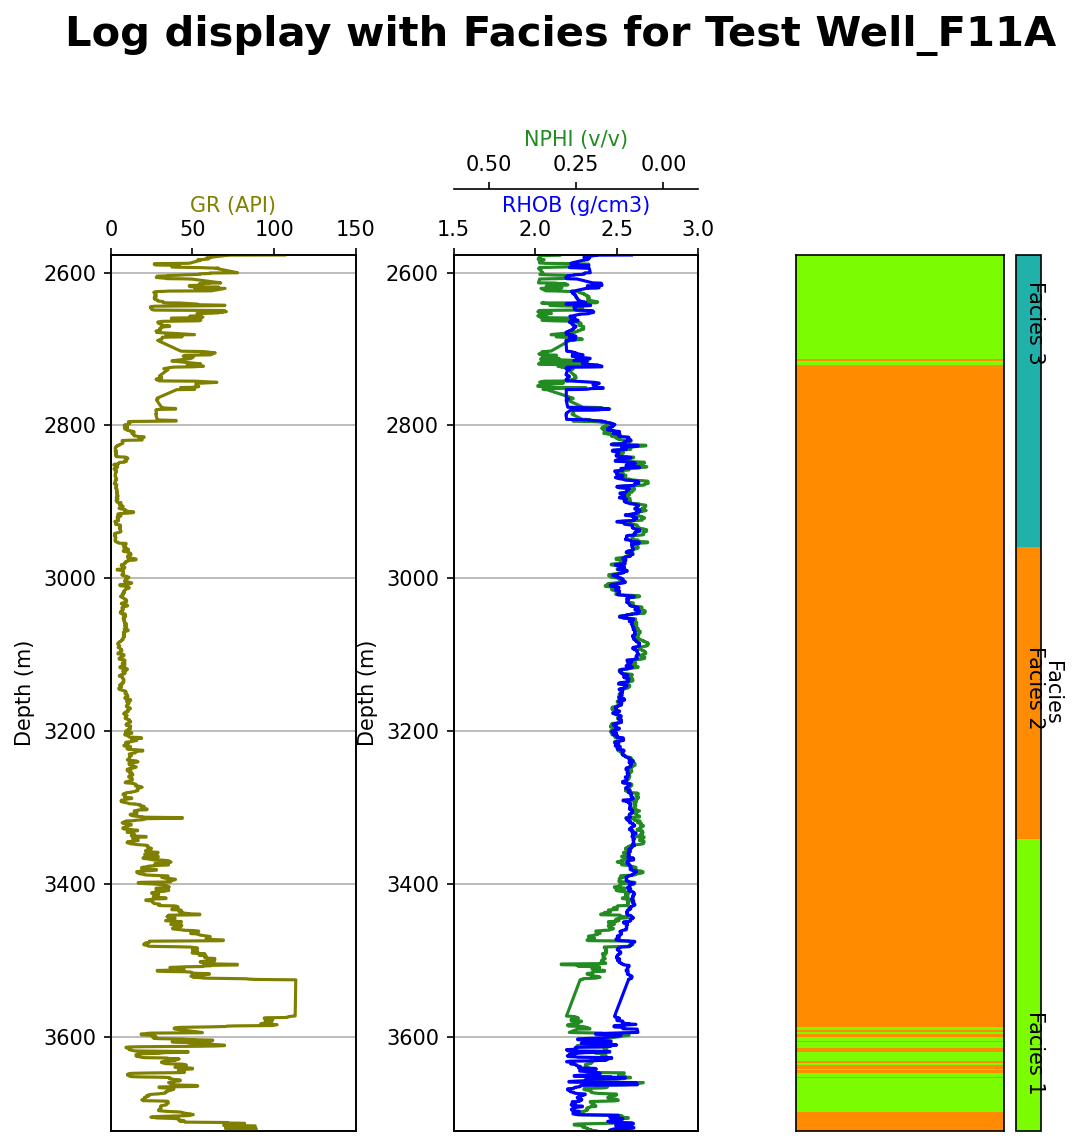

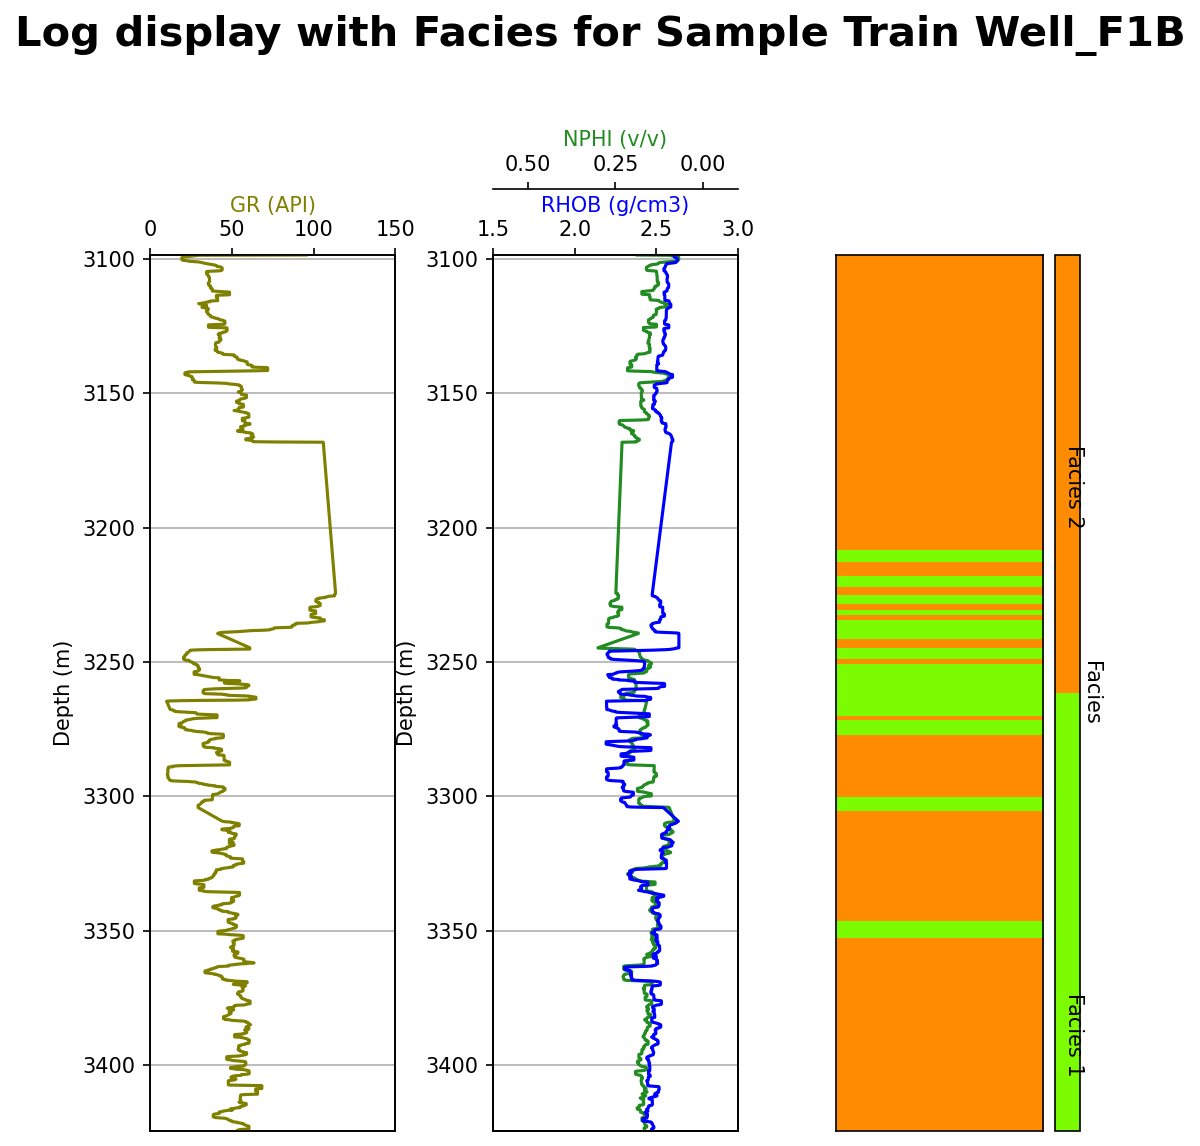

In [25]:
# check out statistics by well 
well_stat=DT_df.groupby(['WELL_NAME']).describe()
print(well_stat)

# create blind test data with Well_F11A
DT_blind = DT_df[DT_df['WELL_NAME'] == 'Well_F11A']
DT = DT_df[DT_df['WELL_NAME'] != 'Well_F11A']

# Visualising the zone clusters
log_plot (DT_blind, name='Facies', ycbar=10, title='Log display with Facies for Test')
log_plot (DT[DT['WELL_NAME'] == 'Well_F1B'], name='Facies', ycbar=10,
          title='Log display with Facies for Sample Train')

Before applying noise-filter [DT]
                  GR          CALI          RHOB          NPHI
count  11309.000000  11309.000000  11309.000000  11309.000000
mean      39.709169      8.545848      2.297656      0.236401
std       17.714187      0.061443      0.079774      0.046744
min        2.385800      8.449700      2.188900      0.090000
25%       29.049801      8.500000      2.231700      0.203600
50%       34.900000      8.546900      2.280000      0.231836
75%       49.727001      8.578000      2.351000      0.260500
max      115.918297      8.759900      2.541200      0.363877
After applying noise-filter [DT]
                  GR          CALI          RHOB          NPHI
count  11309.000000  11309.000000  11309.000000  11309.000000
mean      39.764625      8.546301      2.298038      0.237333
std       17.408057      0.060400      0.077713      0.045344
min        2.565900      8.450000      2.189000      0.131900
25%       29.371000      8.500000      2.233100      0.206900
5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'C': 100.0, 'gamma': 15.848931924611133}
Before applying noise-filter [DT]
                 GR         CALI         RHOB         NPHI
count  1980.000000  1980.000000  1980.000000  1980.000000
mean     37.397576     8.592242     2.266694     0.243205
std      12.900160     0.037910     0.056285     0.058827
min       9.232000     8.535000     2.189000     0.122000
25%      28.708250     8.547000     2.227000     0.206000
50%      34.006000     8.578000     2.250000     0.232500
75%      47.080000     8.625000     2.299000     0.282250
max      77.612000     8.703000     2.417000     0.359000
After applying noise-filter [DT]
                 GR         CALI         RHOB         NPHI
count  1980.000000  1980.000000  1980.000000  1980.000000
mean     37.463864     8.592419     2.267425     0.244292
std      12.473299     0.037875     0.054167     0.057861
min       9.697000     8.547000     2.190000     0.128000
25%      28.833000     8.547000     2.228750     0.207000
50%      34.006000 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'C': 100.0, 'gamma': 15.848931924611133}
Before applying noise-filter [DT]
                 GR         CALI         RHOB         NPHI
count  7929.000000  7929.000000  7929.000000  7929.000000
mean     19.553630     8.648141     2.554339     0.115879
std      19.909392     0.032306     0.048595     0.045391
min       1.812000     8.578000     2.336000     0.043000
25%       7.518000     8.625000     2.520000     0.084000
50%      10.663000     8.625000     2.563000     0.108000
75%      25.452000     8.672000     2.592000     0.136000
max     113.306000     8.750000     2.642000     0.295000
After applying noise-filter [DT]
                 GR         CALI         RHOB         NPHI
count  7929.000000  7929.000000  7929.000000  7929.000000
mean     19.691257     8.648410     2.555150     0.116386
std      19.989280     0.032091     0.047376     0.045282
min       1.975000     8.578000     2.364000     0.044000
25%       7.551000     8.625000     2.521000     0.085000
50%      10.696000 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Before applying noise-filter [DT]
                GR        CALI        RHOB        NPHI
count  131.000000  131.000000  131.000000  131.000000
mean   109.653201    8.683221    2.472551    0.300616
std      3.287246    0.029342    0.026616    0.016868
min     99.822000    8.500600    2.447700    0.279000
25%    107.053000    8.672000    2.460500    0.286000
50%    108.935000    8.687000    2.464000    0.296000
75%    113.088000    8.703000    2.472000    0.309200
max    115.940002    8.750000    2.599000    0.344000
After applying noise-filter [DT]
                GR        CALI        RHOB        NPHI
count  131.000000  131.000000  131.000000  131.000000
mean   109.821124    8.686572    2.472721    0.300414
std      2.886913    0.014995    0.025204    0.015435
min    106.208000    8.671900    2.452000    0.280000
25%    107.053000    8.672000    2.462000    0.292000
50%    108.997000    8.680000    2.465000    0.293000
75%    112.642850    8.703000    2.472000    0.309200
max    114.71

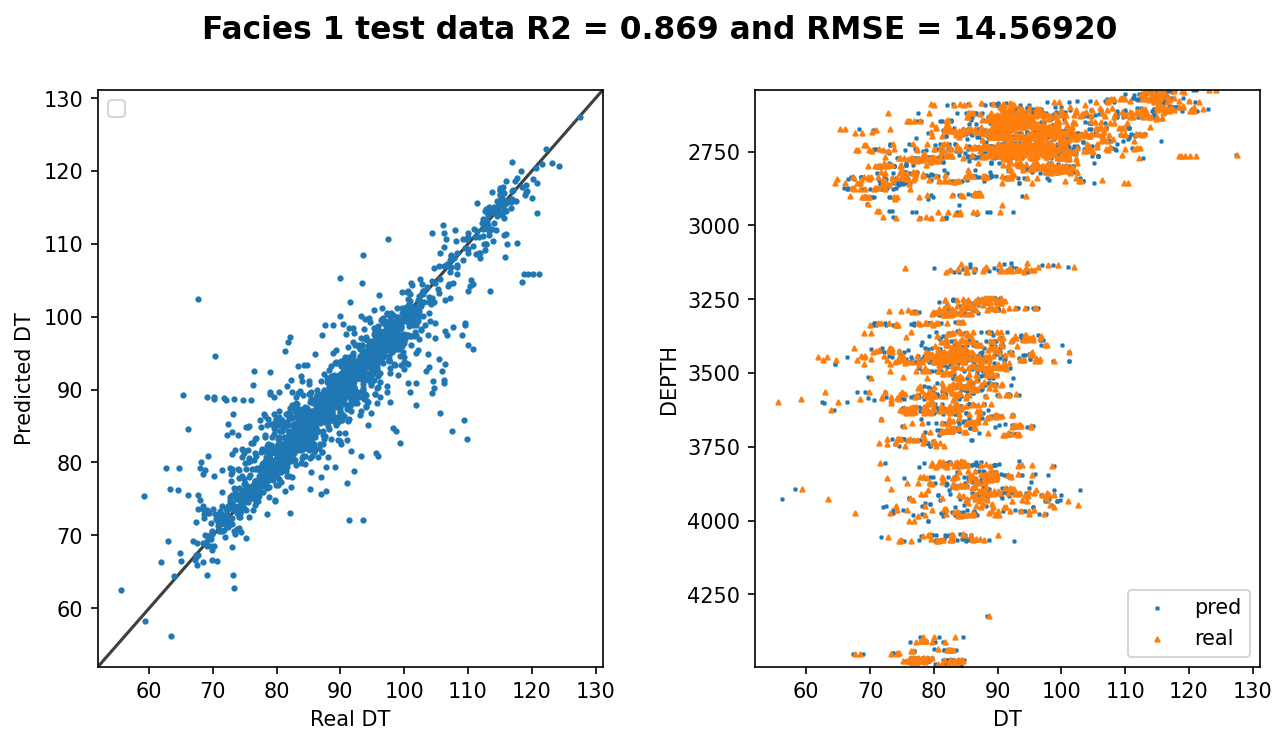

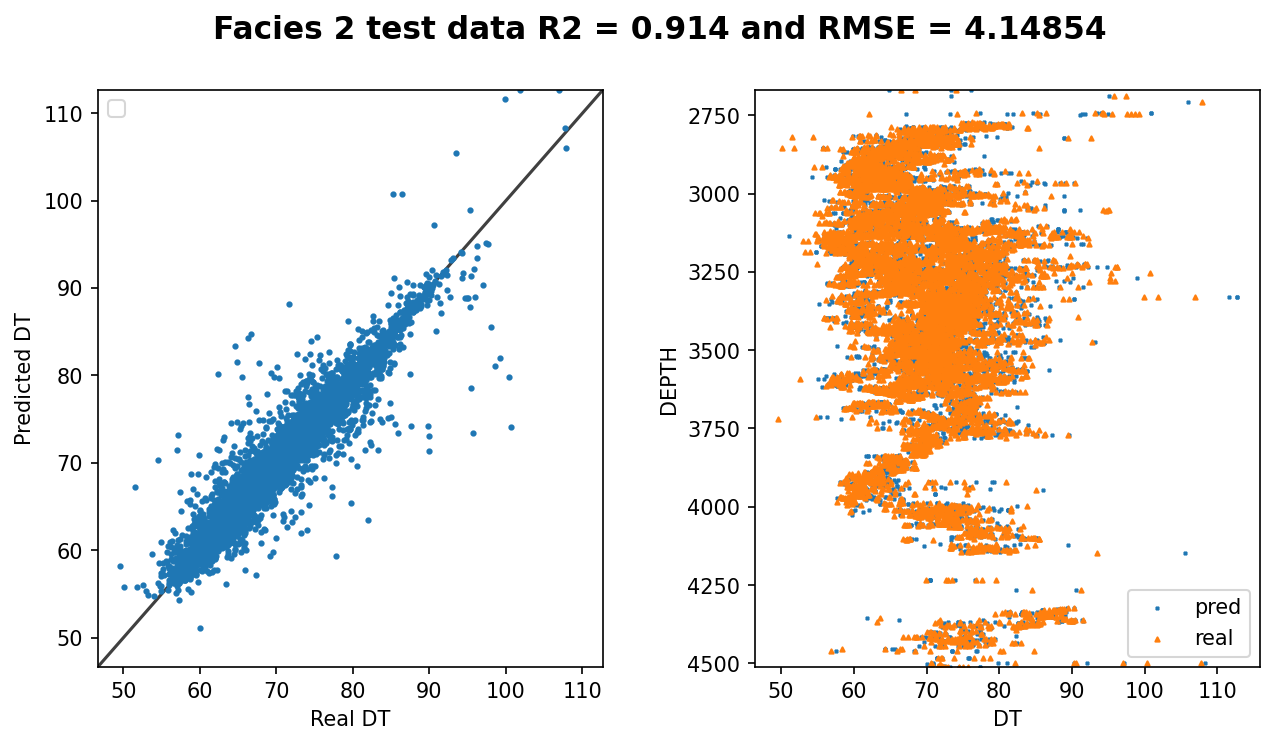

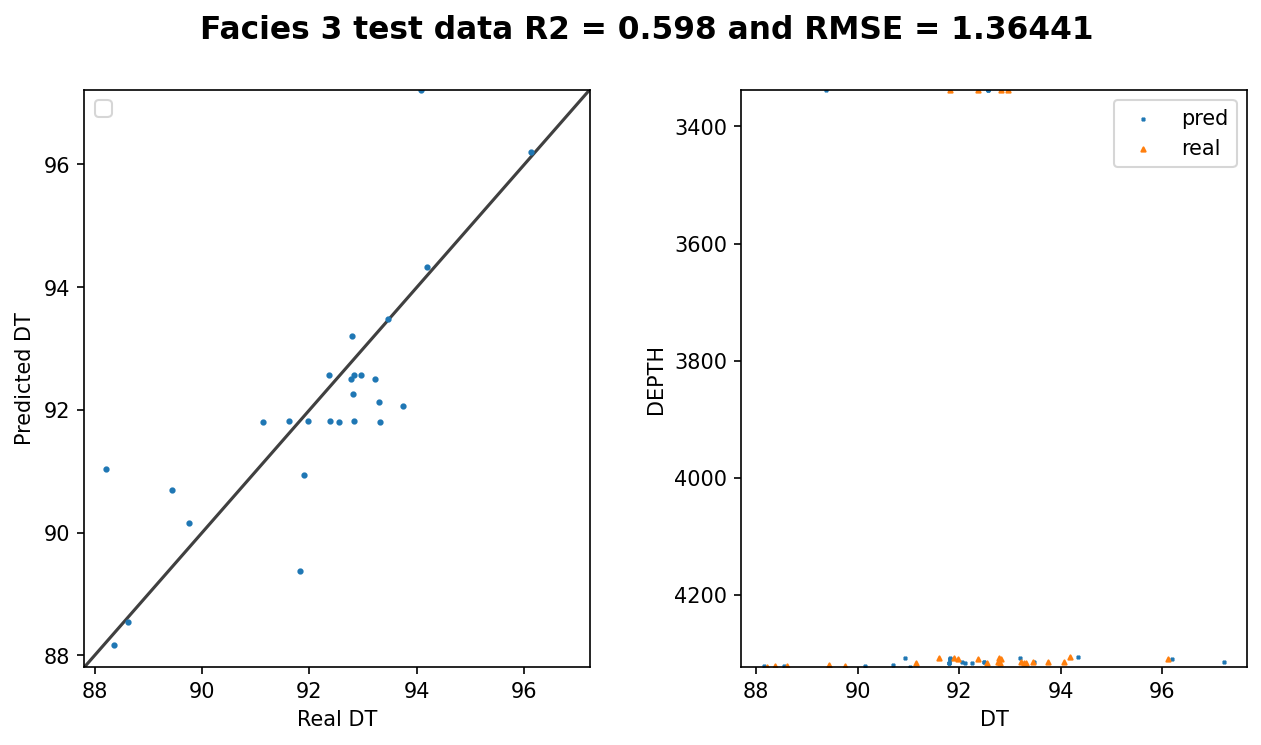

In [26]:
# Split dataset into target and attributes
# arrays for saving predictions
#Y_pred_DT=np.repeat(np.zeros(DT_blind.shape[0]),2).reshape((-1, 2))
Y_pred_DT=np.zeros(DT_blind.shape[0])
name='DT'
for i in DT['Facies'].unique():
    DT_split=DT[DT.Facies.values==i].copy()
    target = DT_split[['DEPTH', 'DT']]
    target.set_index('DEPTH', inplace=True)
    attributes = DT_split.drop(['WELL_NAME', 'DEPTH', 'DT', 'Facies'], axis = 1)
    attributes = apply_filter(attributes, name=name)
    
    model, Prescale, results = model_predict(attributes,target,'Facies %s' % str(i+1), name=name)
    print(model.best_params_)
    
    #BLIND WELL TEST
    DT_blind_split=DT_blind[DT_blind.Facies.values==i].copy()
    Y_blind = DT_blind_split[['DEPTH', 'DT']]
    Y_blind.set_index('DEPTH', inplace=True)
    X_blind = DT_blind_split.drop(['WELL_NAME', 'DEPTH', 'DT', 'Facies'], axis = 1)
    X_blind = apply_filter(X_blind, name=name)
    

    # save the prediction
    Y_blind_pred = model.predict(Prescale.transform(X_blind))
    Y_pred_DT[DT_blind.Facies.values==i]=Y_blind_pred
    
Y_test_DT=DT_blind['DT'].values

Text(0.5, 1.0, 'R2 = 0.783 and RMSE = 30.07927')

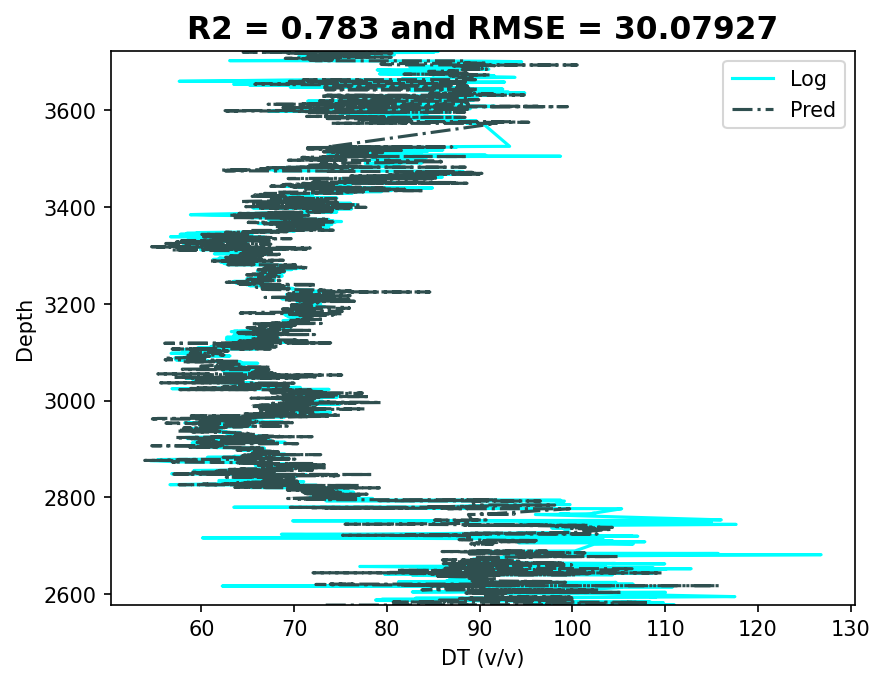

In [27]:
#test the accuracy
mse = mean_squared_error(Y_test_DT, Y_pred_DT)
r2 = r2_score(Y_test_DT, Y_pred_DT)

plt.plot(Y_test_DT, DT_blind.DEPTH, c='cyan')
plt.plot(Y_pred_DT, DT_blind.DEPTH, c='darkslategrey', linestyle='-.')
plt.xlabel('DT (v/v)')
#plt.xlim(0,1) 
plt.ylim(np.min(DT_blind.DEPTH),np.max(DT_blind.DEPTH)) 
plt.ylabel('Depth')
plt.legend(['Log', 'Pred'], loc=0)
plt.title('R2 = {:.3f} and RMSE = {:.5f}'.format(r2, mse), weight='bold', fontsize=15)

### DTS Prediction

<class 'pandas.core.frame.DataFrame'>
Index: 119180 entries, 36157 to 359567
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  119180 non-null  object 
 1   DEPTH      119180 non-null  float64
 2   GR         119180 non-null  float64
 3   CALI       119180 non-null  float64
 4   RHOB       119180 non-null  float64
 5   NPHI       119180 non-null  float64
 6   PEF        111629 non-null  float64
 7   DTS        42812 non-null   float64
 8   Facies     119180 non-null  int32  
dtypes: float64(7), int32(1), object(1)
memory usage: 8.6+ MB
None
Before anomaly treatment
                  GR          CALI          RHOB          NPHI           PEF  \
count  42812.000000  42812.000000  42812.000000  42812.000000  42812.000000   
mean      34.318402      8.652205      2.489143      0.156701      7.328544   
std       45.230072      0.056168      0.134222      0.089918      1.195515   
min        1.812000      8.5000

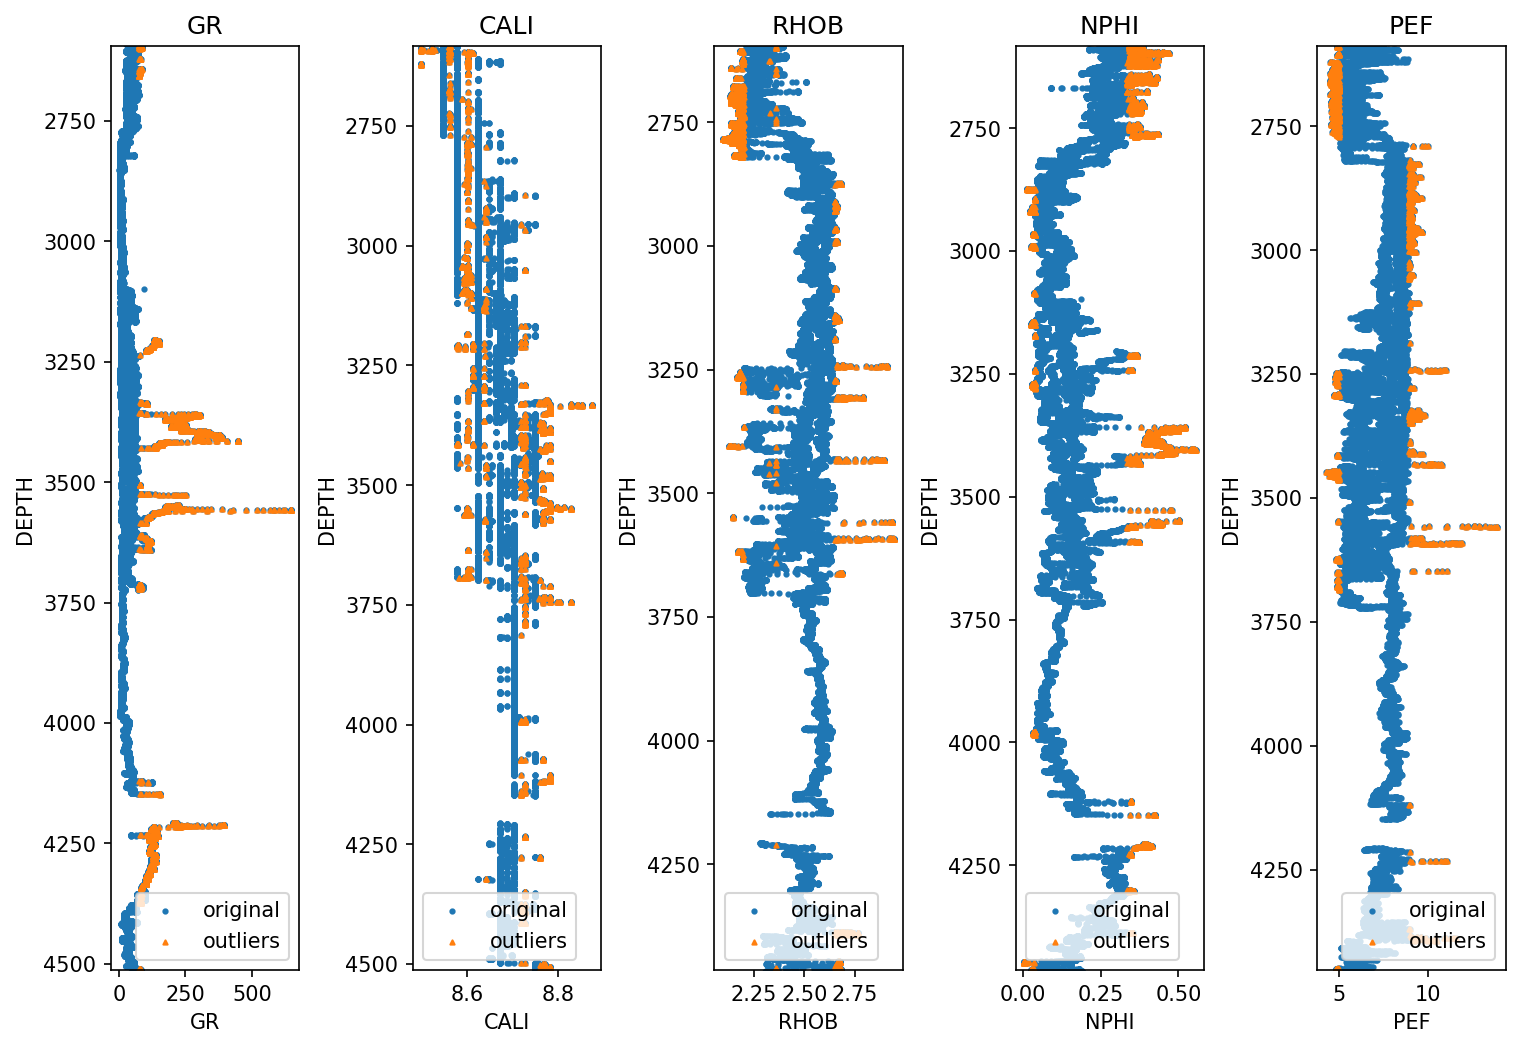

In [29]:
DTS = dfm.drop(['BS', 'ROP', 'RM', 'RD', 'DT', 'VCARB', 'VSH', 'PHIF', 'SW',# 'PEF',
                  'KLOGH', 'SAND_FLAG', 'CARB_FLAG', 'COAL_FLAG'], axis=1) 
print(DTS.info())
# drop all nan values from VShale data
DTS.dropna(inplace=True)
DTS.shape

DTS_df=outlier_removal(DTS, ind=-2)

Text(0.5, 1.0, 'DTS correlation')

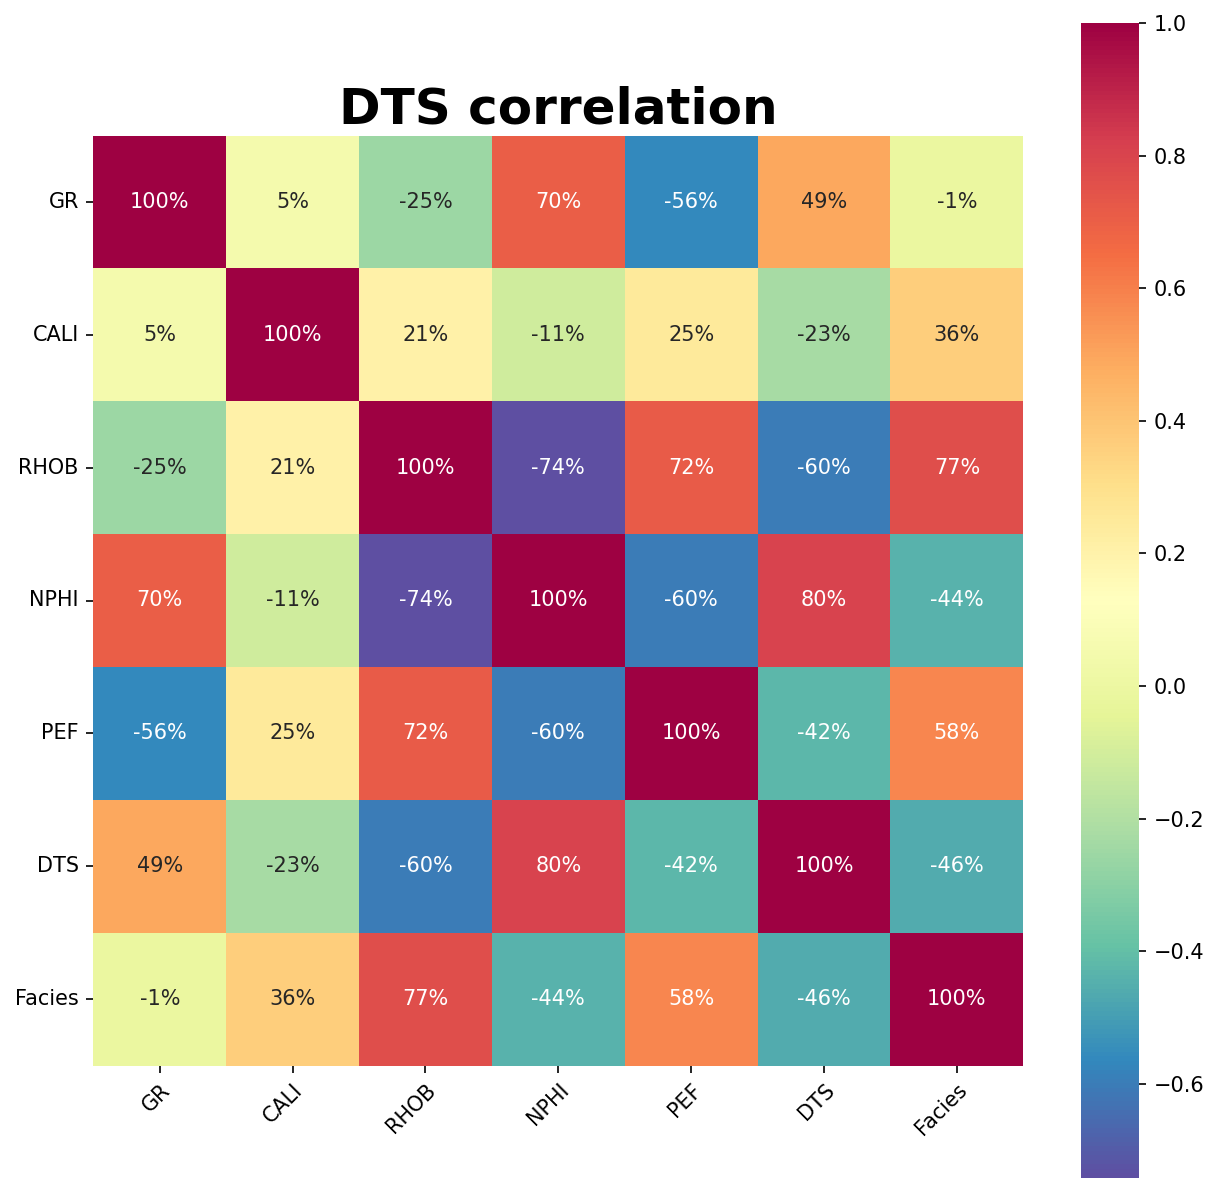

In [30]:
# Visualize correlation
data_scaled = DataFrame(Prescale.fit_transform(DTS_df.drop(['WELL_NAME', 'DEPTH'], axis = 1)), 
                        index=DTS_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).index,
                        columns=DTS_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).columns)
plt.figure(figsize= (10,10))
# Draw a heatmap
ax=sns.heatmap(data_scaled.corr(method='pearson'), annot=True, fmt ='.0%', cmap="Spectral_r", square=True)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
ax.set_title('DTS correlation',weight='bold', fontsize=24)

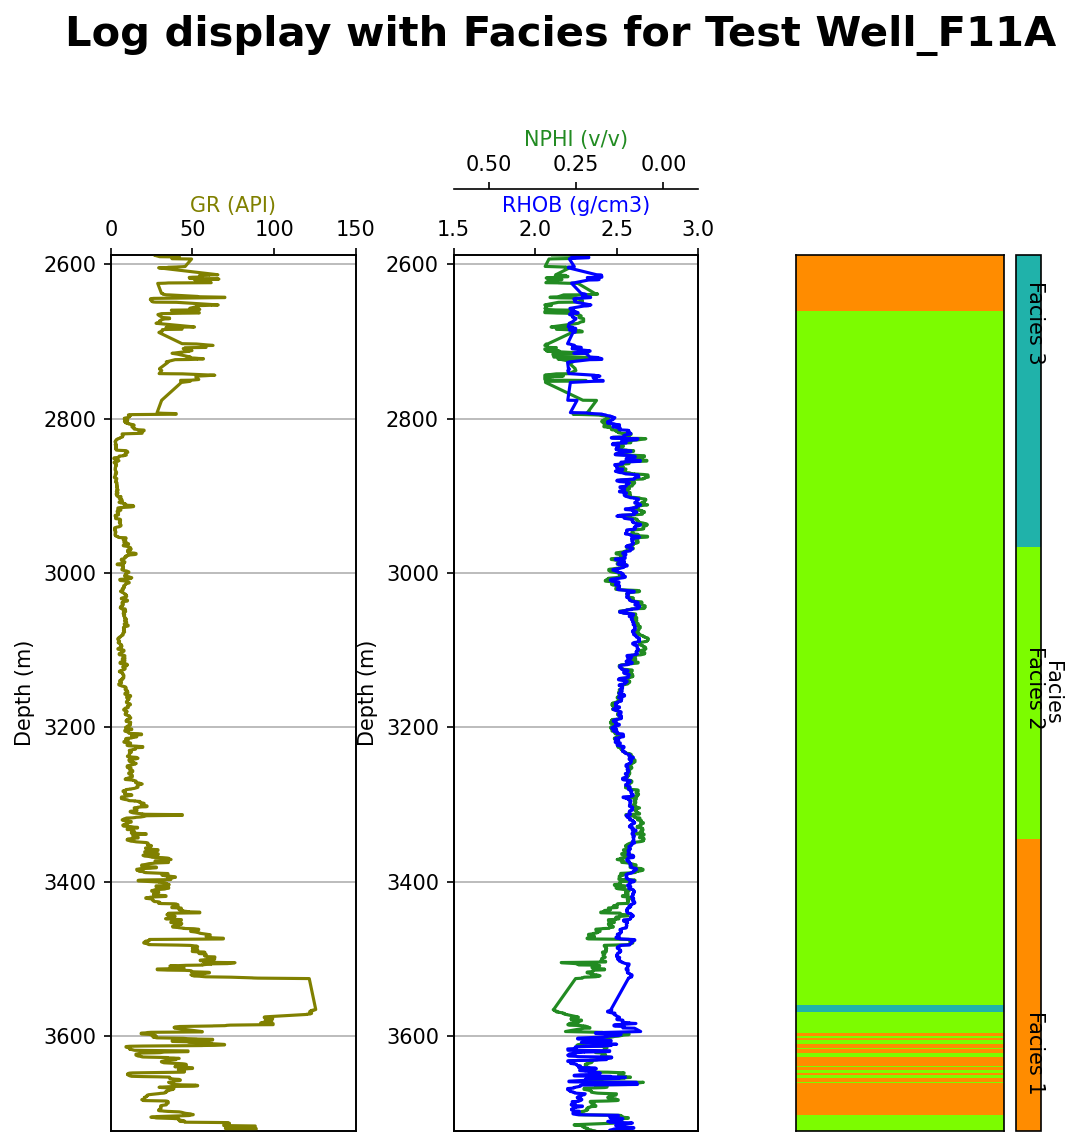

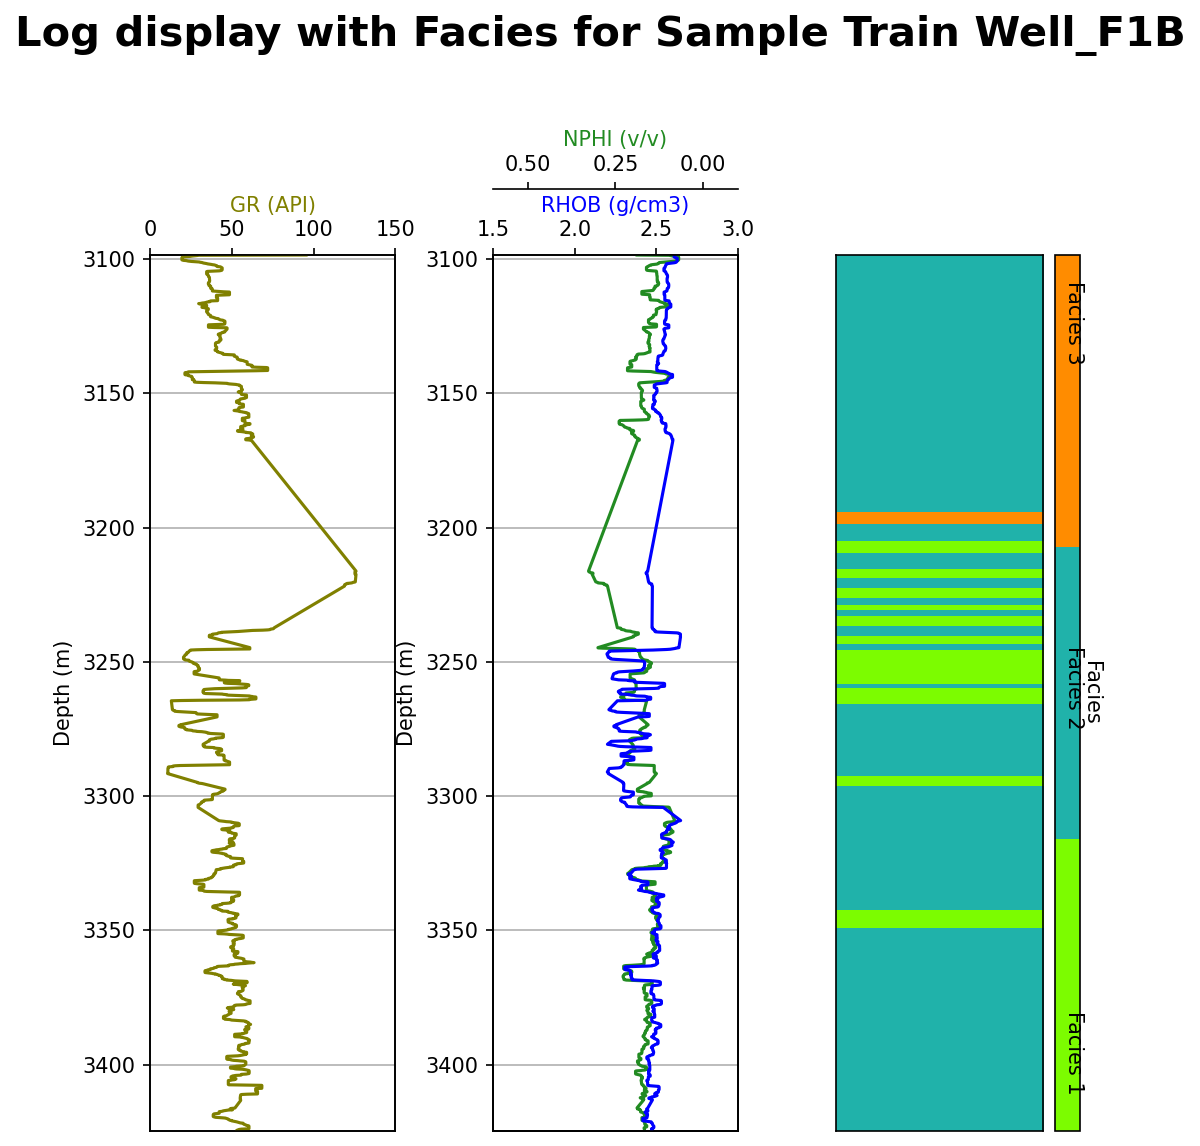

In [31]:
# create blind test data with Well_F11A
DTS_blind = DTS_df[DTS_df['WELL_NAME'] == 'Well_F11A']
DTS = DTS_df[DTS_df['WELL_NAME'] != 'Well_F11A']

# Visualising the zone clusters
log_plot (DTS_blind, name='Facies', ycbar=10, title='Log display with Facies for Test')
log_plot (DTS[DTS['WELL_NAME'] == 'Well_F1B'], name='Facies', ycbar=10,
          title='Log display with Facies for Sample Train')

Before applying noise-filter [DTS]
                 GR         CALI         RHOB         NPHI          PEF
count  2453.000000  2453.000000  2453.000000  2453.000000  2453.000000
mean     36.001752     8.605512     2.291113     0.227045     5.636893
std      12.321740     0.047713     0.063197     0.042527     0.565551
min       7.801400     8.546900     2.198900     0.090000     5.016600
25%      27.618000     8.578000     2.237900     0.193100     5.277000
50%      33.452300     8.578100     2.287000     0.223000     5.470000
75%      44.073500     8.663700     2.327000     0.251000     5.762000
max      95.859800     8.703200     2.518600     0.339000     8.791000
After applying noise-filter [DTS]
                 GR         CALI         RHOB         NPHI          PEF
count  2453.000000  2453.000000  2453.000000  2453.000000  2453.000000
mean     36.088977     8.605519     2.292299     0.227762     5.628897
std      11.581761     0.047475     0.060610     0.041279     0.510096
min   

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             refit='r2', scoring=['neg_mean_squared_error', 'r2'])
Best: 0.901889 using {'C': 100.0, 'gamma': 0.6309573444801936}
         means     stdev                                       params
rank                                                                 
1     0.901889  0.025432    {'C': 100.0, 'gamma': 0.6309573444801936}
2     0.874580  0.042067    {'C': 100.0, 'gamma': 15.848931924611133}
3     0.816111  0.037689     {'C': 10.0, 'gamma': 0.6309573444801936}
4     0.684943  0.044802  {'C': 100.0, 'gamma': 0.025118864315095808}
5     0.647535  0.039161   {'C': 10.0, 'gamma': 0.025118864315095808}
6     0.619079  0.064502     {'C': 10.0, 'gamma': 15.848931924611133}
7     0.567614  0.026369                 {'C': 100.0, 'gamma': 0.001}
8     0.526073  0.034035      {'C': 1.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'C': 100.0, 'gamma': 15.848931924611133}
Before applying noise-filter [DTS]
                 GR         CALI        RHOB         NPHI          PEF
count  7708.000000  7708.000000  7708.00000  7708.000000  7708.000000
mean     18.830972     8.647773     2.55516     0.114425     7.952697
std      18.722100     0.031630     0.04814     0.043763     0.620056
min       1.812000     8.578000     2.33600     0.043000     5.086000
25%       7.516000     8.625000     2.52100     0.083000     7.755750
50%      10.590000     8.625000     2.56400     0.107000     8.153000
75%      24.313000     8.672000     2.59200     0.135000     8.363000
max     121.560000     8.750000     2.64700     0.292000     8.919000
After applying noise-filter [DTS]
                 GR         CALI         RHOB         NPHI          PEF
count  7708.000000  7708.000000  7708.000000  7708.000000  7708.000000
mean     18.937102     8.648131     2.555847     0.114874     7.959519
std      18.742412     0.031370     0.047034

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             refit='r2', scoring=['neg_mean_squared_error', 'r2'])
Best: 0.775004 using {'C': 10.0, 'gamma': 0.6309573444801936}
         means     stdev                                       params
rank                                                                 
1     0.775004  0.122728     {'C': 10.0, 'gamma': 0.6309573444801936}
2     0.709837  0.309956    {'C': 100.0, 'gamma': 0.6309573444801936}
3     0.643578  0.168950  {'C': 100.0, 'gamma': 0.025118864315095808}
4     0.633849  0.171703     {'C': 10.0, 'gamma': 15.848931924611133}
5     0.602279  0.317862    {'C': 100.0, 'gamma': 15.848931924611133}
6     0.500885  0.134741   {'C': 10.0, 'gamma': 0.025118864315095808}
7     0.479350  0.139223      {'C': 1.0, 'gamma': 0.6309573444801936}
8     0.360191  0.109253               

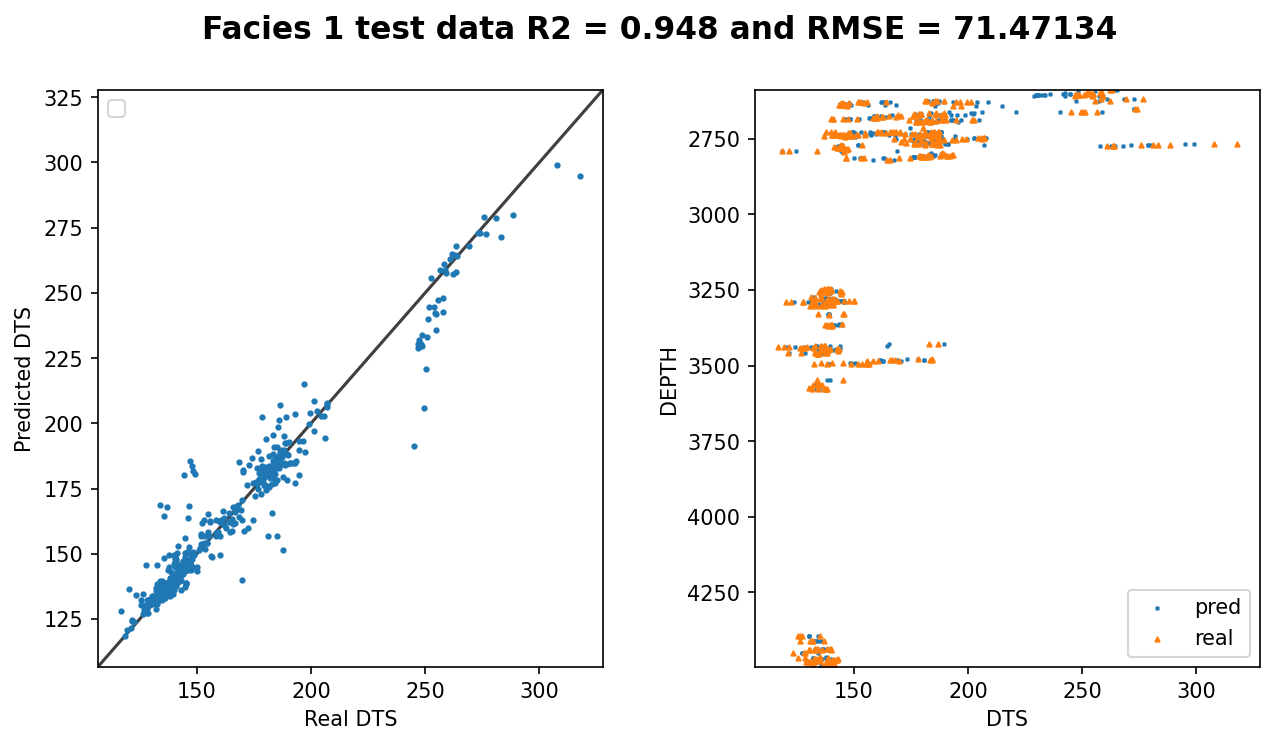

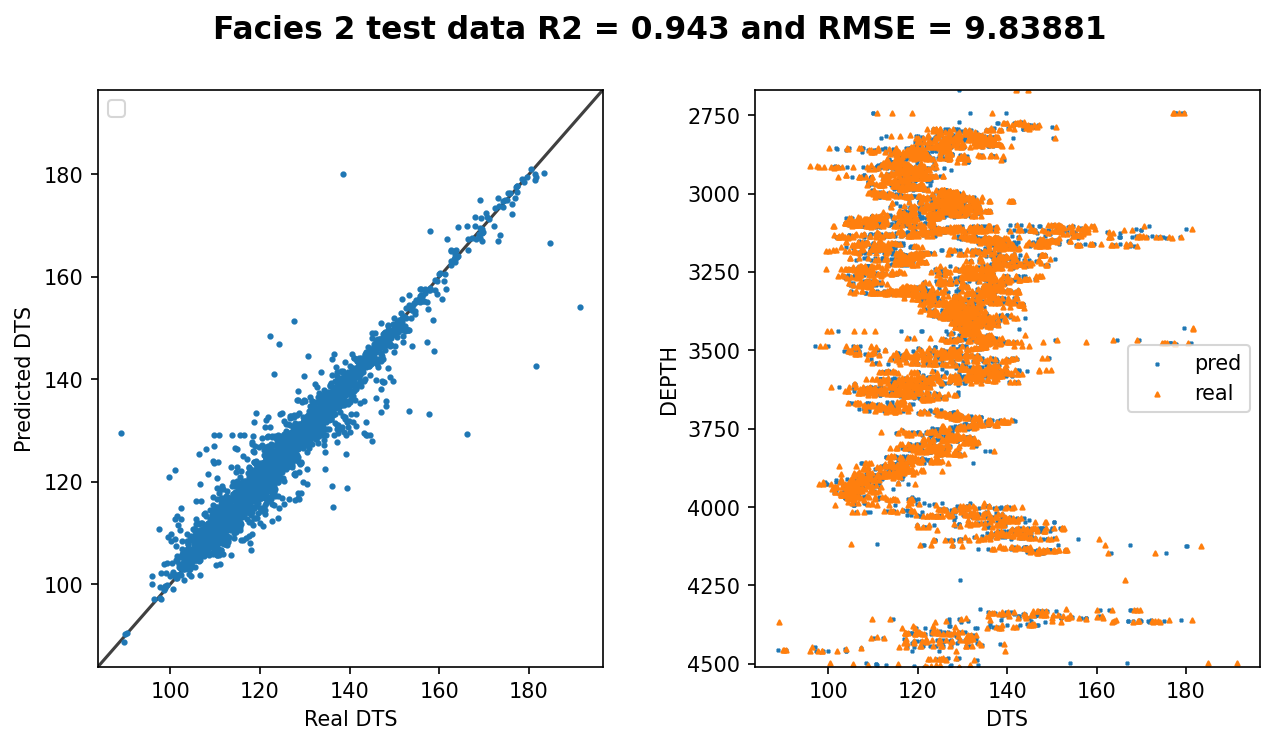

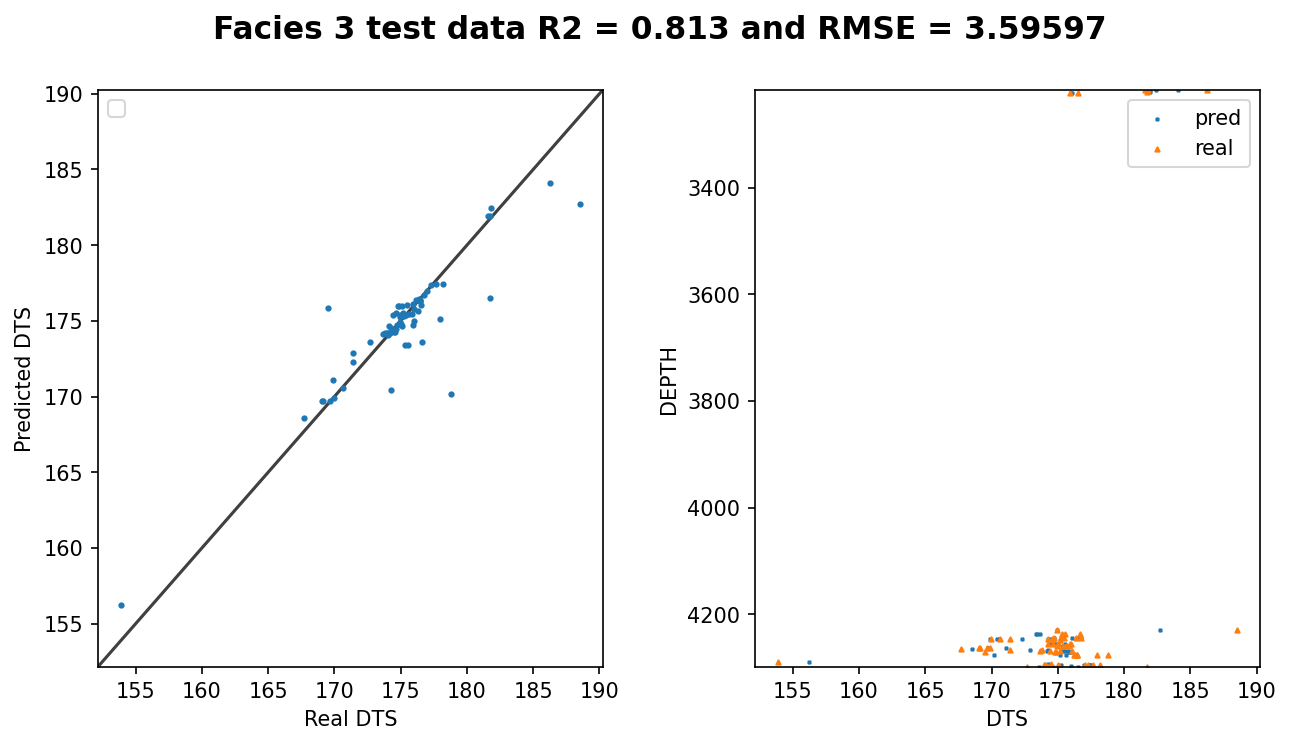

In [32]:
# Split dataset into target and attributes
# arrays for saving predictions
Y_pred_DTS=np.zeros(DTS_blind.shape[0])
name='DTS'
for i in DTS['Facies'].unique():
    DTS_split=DTS[DTS.Facies.values==i].copy()
    target = DTS_split[['DEPTH', 'DTS']]
    target.set_index('DEPTH', inplace=True)
    attributes = DTS_split.drop(['WELL_NAME', 'DEPTH', 'DTS', 'Facies'], axis = 1)
    attributes = apply_filter(attributes, name=name)
    
    model, Prescale, results = model_predict(attributes,target,'Facies %s' % str(i+1), name=name)
    print(model.best_params_)
    
    #BLIND WELL TEST
    DTS_blind_split=DTS_blind[DTS_blind.Facies.values==i].copy()
    Y_blind = DTS_blind_split[['DEPTH', 'DTS']]
    Y_blind.set_index('DEPTH', inplace=True)
    X_blind = DTS_blind_split.drop(['WELL_NAME', 'DEPTH', 'DTS', 'Facies'], axis = 1)
    X_blind = apply_filter(X_blind, name=name)
    

    # save the prediction
    Y_blind_pred = model.predict(Prescale.transform(X_blind))
    Y_pred_DTS[DTS_blind.Facies.values==i]=Y_blind_pred
    
Y_test_DTS=DTS_blind['DTS'].values

Text(0.5, 1.0, 'R2 = 0.628 and RMSE = 324.07822')

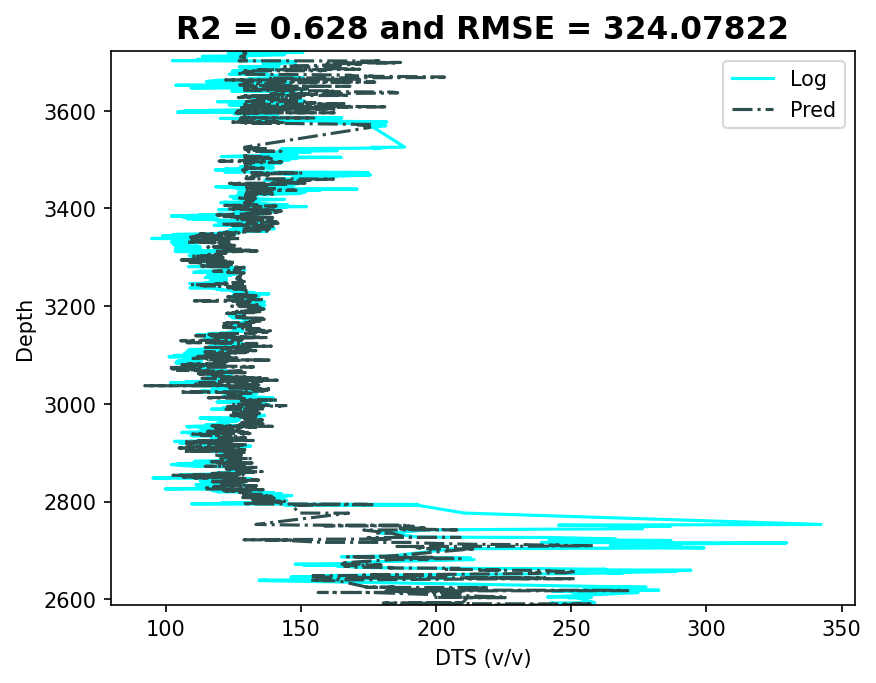

In [33]:
#test the accuracy
mse = mean_squared_error(Y_test_DTS, Y_pred_DTS)
r2 = r2_score(Y_test_DTS, Y_pred_DTS)

plt.plot(Y_test_DTS, DTS_blind.DEPTH, c='cyan')
plt.plot(Y_pred_DTS, DTS_blind.DEPTH, c='darkslategrey', linestyle='-.')
plt.xlabel('DTS (v/v)')
#plt.xlim(0,1) 
plt.ylim(np.min(DTS_blind.DEPTH),np.max(DTS_blind.DEPTH)) 
plt.ylabel('Depth')
plt.legend(['Log', 'Pred'], loc=0)
plt.title('R2 = {:.3f} and RMSE = {:.5f}'.format(r2, mse), weight='bold', fontsize=15)

### PORO Prediction

<class 'pandas.core.frame.DataFrame'>
Index: 119180 entries, 36157 to 359567
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  119180 non-null  object 
 1   DEPTH      119180 non-null  float64
 2   GR         119180 non-null  float64
 3   RHOB       119180 non-null  float64
 4   NPHI       119180 non-null  float64
 5   PHIF       68219 non-null   float64
 6   Facies     119180 non-null  int32  
dtypes: float64(5), int32(1), object(1)
memory usage: 6.8+ MB
None
Before anomaly treatment
                  GR          RHOB          NPHI          PHIF        Facies
count  68219.000000  68219.000000  68219.000000  68219.000000  68219.000000
mean      40.306017      2.408846      0.183202      0.142441      0.528152
std       28.402769      0.156767      0.063395      0.081502      0.526033
min        5.494200      2.057700      0.005000      0.001000      0.000000
25%       20.523900      2.261000      0.146000  

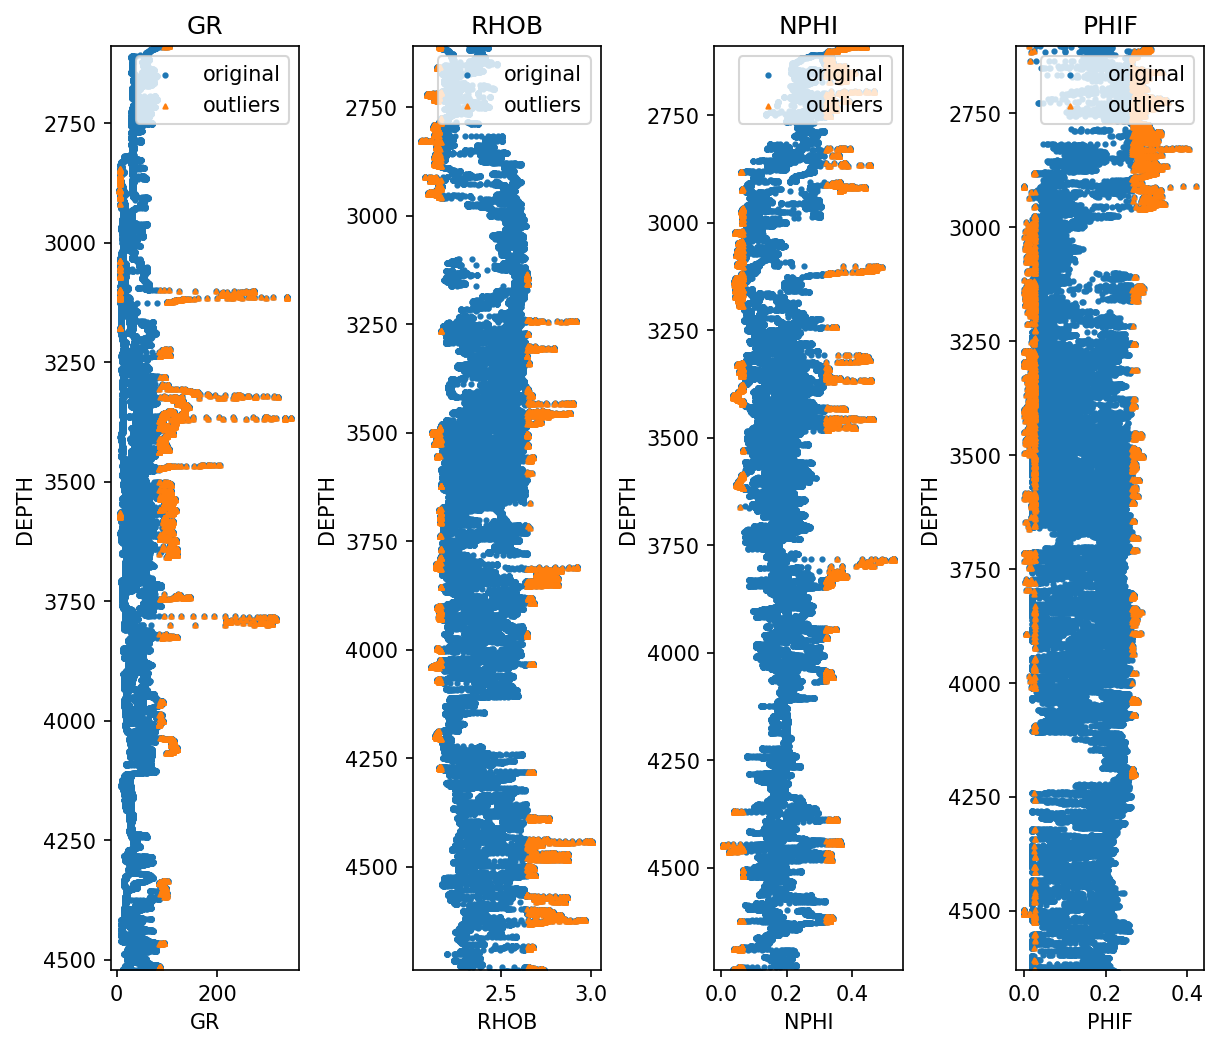

In [34]:
POR = dfm.drop(['BS', 'ROP', 'RM', 'RD', 'PEF', 'DT', 'DTS', 'VCARB', 'VSH', 'SW', 'CALI',
                  'KLOGH', 'SAND_FLAG', 'CARB_FLAG', 'COAL_FLAG'], axis=1) 
print(POR.info())
# drop all nan values from data
POR.dropna(inplace=True)
POR.shape

POR_df=outlier_removal(POR, ind=-1)

Text(0.5, 1.0, 'PHIF correlation')

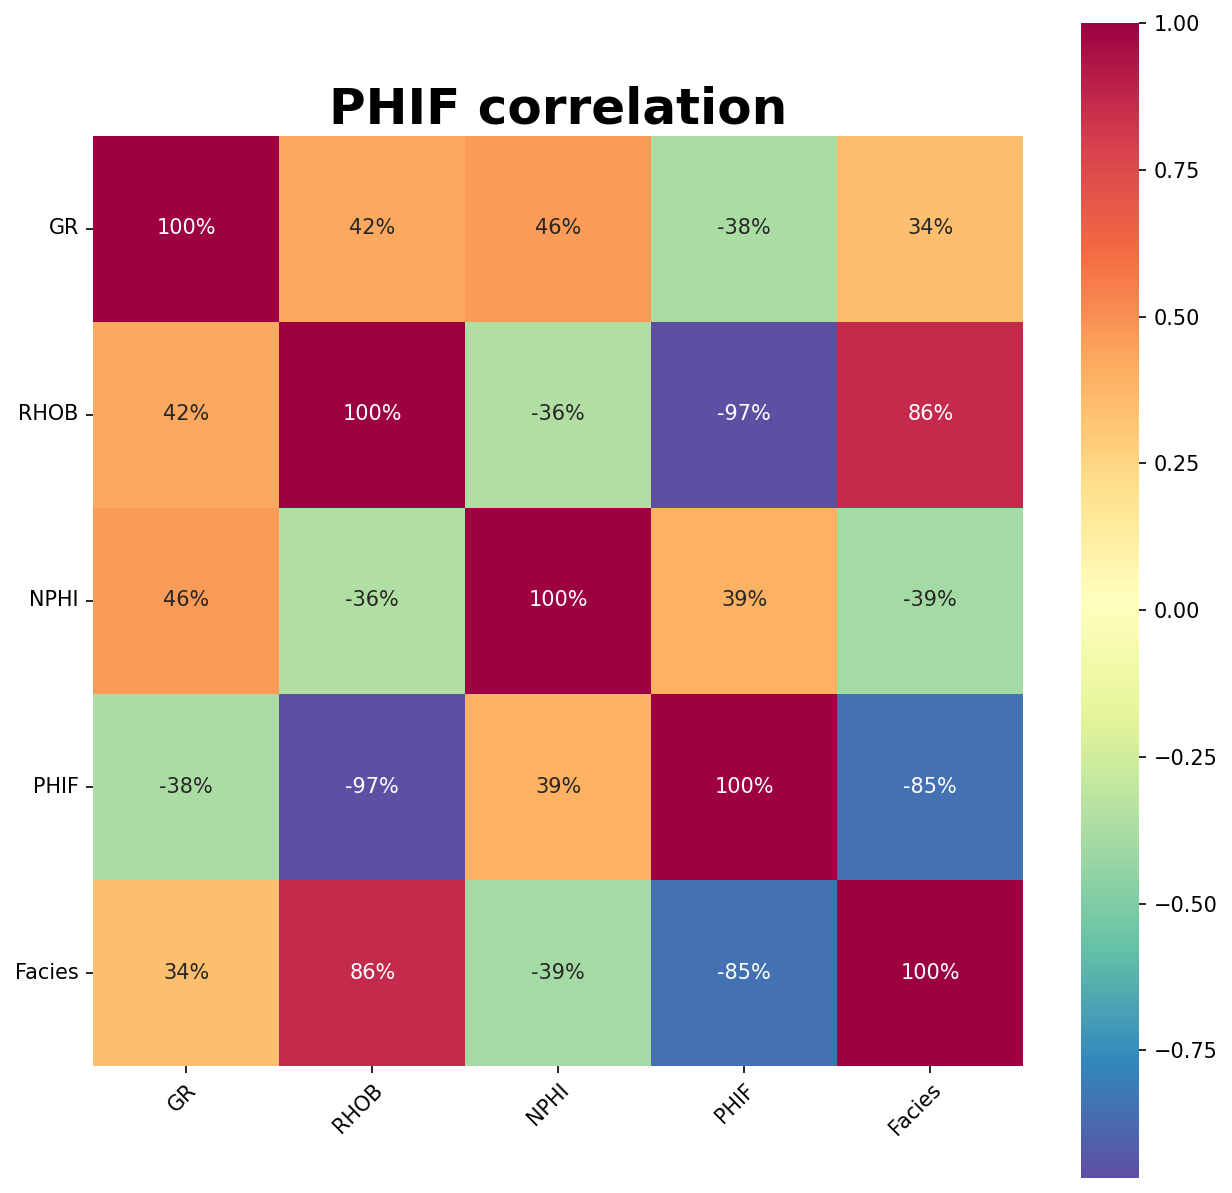

In [35]:
# Visualize correlation
data_scaled = DataFrame(Prescale.fit_transform(POR_df.drop(['WELL_NAME', 'DEPTH'], axis = 1)), 
                        index=POR_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).index,
                        columns=POR_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).columns)
plt.figure(figsize= (10,10))
# Draw a heatmap
ax=sns.heatmap(data_scaled.corr(method='pearson'), annot=True, fmt ='.0%', cmap="Spectral_r", square=True)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
ax.set_title('PHIF correlation',weight='bold', fontsize=24)

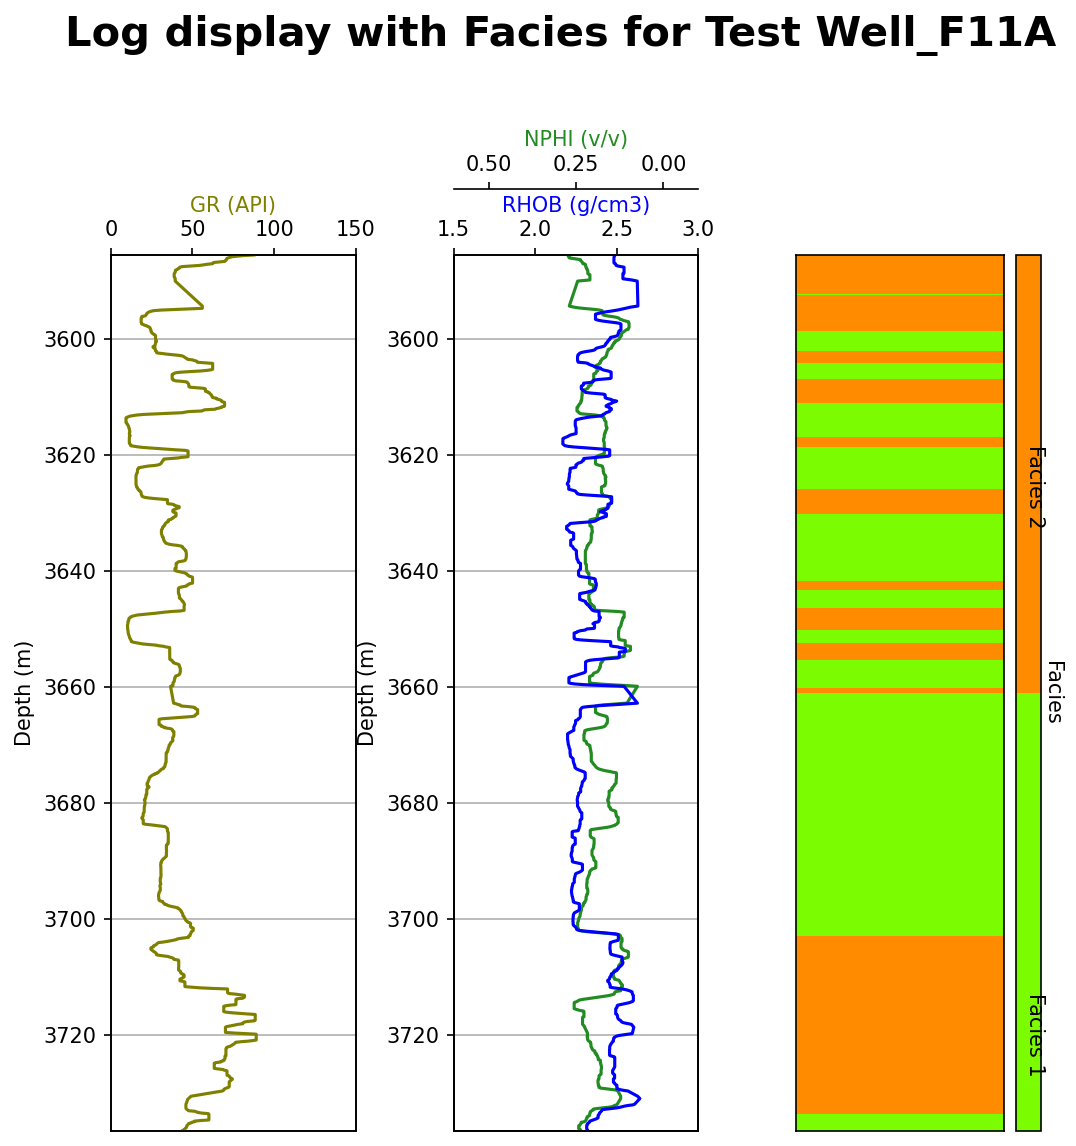

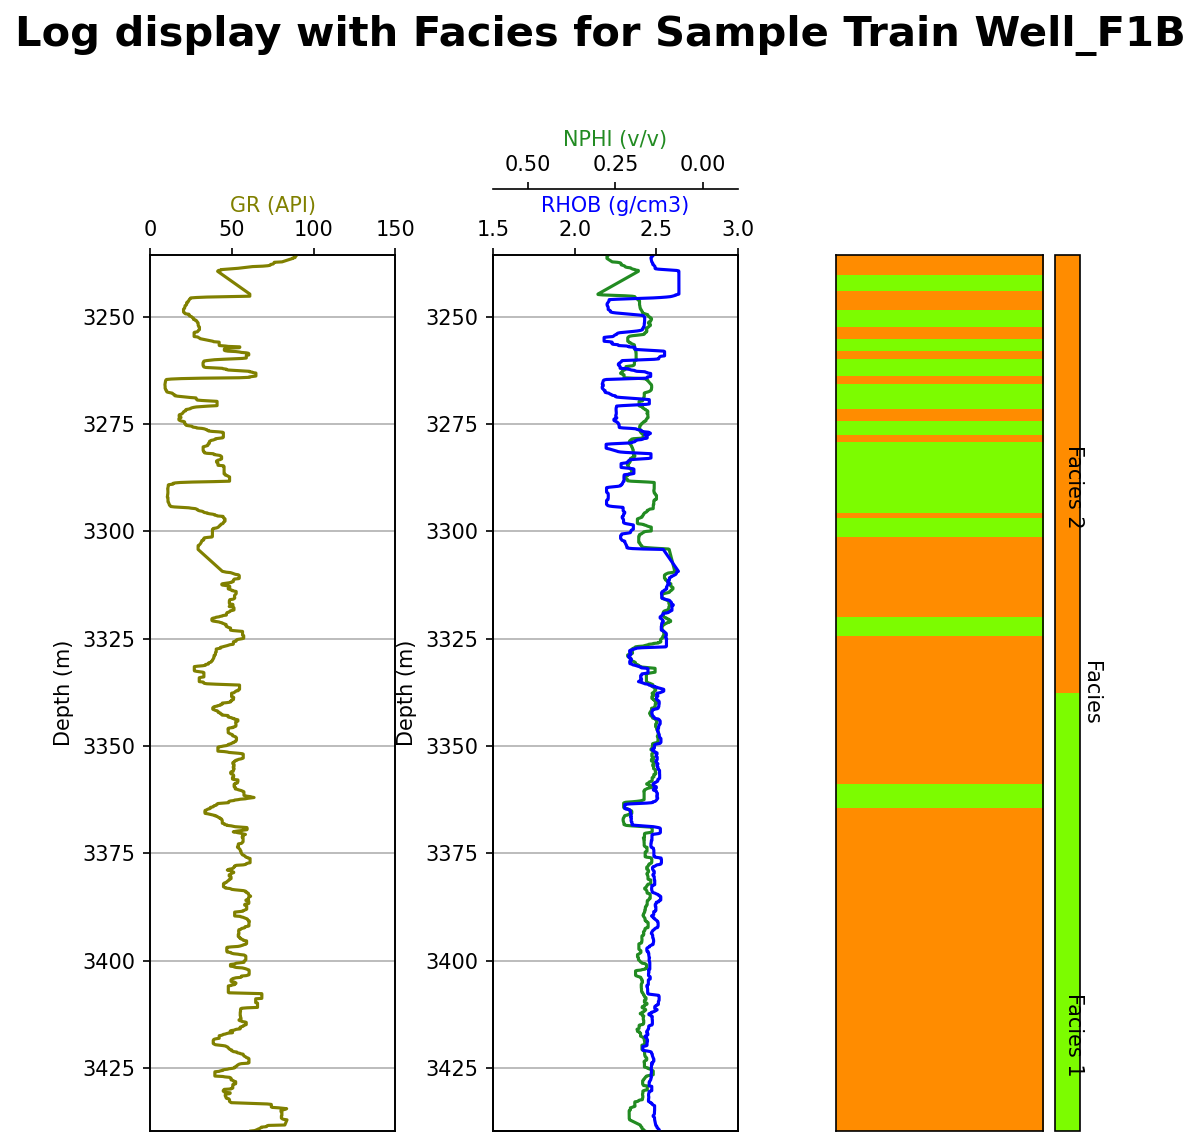

In [36]:
# create blind test data with Well_F11A
POR_blind = POR_df[POR_df['WELL_NAME'] == 'Well_F11A']
POR = POR_df[POR_df['WELL_NAME'] != 'Well_F11A']

# Visualising the zone clusters
log_plot (POR_blind, name='Facies', ycbar=10, title='Log display with Facies for Test')
log_plot (POR[POR['WELL_NAME'] == 'Well_F1B'], name='Facies', ycbar=10,
          title='Log display with Facies for Sample Train')

Before applying noise-filter [PHIF]
                  GR          RHOB          NPHI
count  27592.000000  27592.000000  27592.000000
mean      29.877012      2.280588      0.190701
std       14.809701      0.076276      0.033595
min        7.163100      2.167500      0.081700
25%       17.717525      2.217700      0.164000
50%       27.395300      2.267500      0.189200
75%       39.269400      2.332600      0.211000
max       90.415300      2.565000      0.318591
After applying noise-filter [PHIF]
                  GR          RHOB          NPHI
count  27592.000000  27592.000000  27592.000000
mean      29.934420      2.280969      0.191425
std       14.699354      0.074697      0.033043
min        7.249400      2.169000      0.113300
25%       17.835000      2.219200      0.164600
50%       27.486200      2.268900      0.190000
75%       39.343175      2.332000      0.211800
max       89.837200      2.554000      0.317331


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             refit='r2', scoring=['neg_mean_squared_error', 'r2'])
Best: -0.418149 using {'C': 10.0, 'gamma': 0.6309573444801936}
         means     stdev                                       params
rank                                                                 
1    -0.418149  0.095292     {'C': 10.0, 'gamma': 0.6309573444801936}
2    -0.443164  0.166490    {'C': 100.0, 'gamma': 0.6309573444801936}
3    -0.888725  0.078238      {'C': 1.0, 'gamma': 0.6309573444801936}
4    -1.550306  0.153496   {'C': 10.0, 'gamma': 0.025118864315095808}
5    -1.569017  0.160257  {'C': 100.0, 'gamma': 0.025118864315095808}
6    -1.618642  0.126631                  {'C': 10.0, 'gamma': 0.001}
7    -1.626134  0.112750                   {'C': 1.0, 'gamma': 0.001}
8    -1.649070  0.149837    {'C': 1.0,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             refit='r2', scoring=['neg_mean_squared_error', 'r2'])
Best: 0.042031 using {'C': 100.0, 'gamma': 0.025118864315095808}
         means     stdev                                       params
rank                                                                 
1     0.042031  0.058216  {'C': 100.0, 'gamma': 0.025118864315095808}
2    -0.037024  0.126291     {'C': 10.0, 'gamma': 0.6309573444801936}
2    -0.037024  0.126291    {'C': 100.0, 'gamma': 0.6309573444801936}
4    -0.046319  0.079014   {'C': 10.0, 'gamma': 0.025118864315095808}
5    -0.222209  0.105604      {'C': 1.0, 'gamma': 0.6309573444801936}
6    -0.499478  0.057213                  {'C': 10.0, 'gamma': 0.001}
7    -0.535406  0.066238                   {'C': 1.0, 'gamma': 0.001}
8    -0.545778  0.086261    {'C': 1.

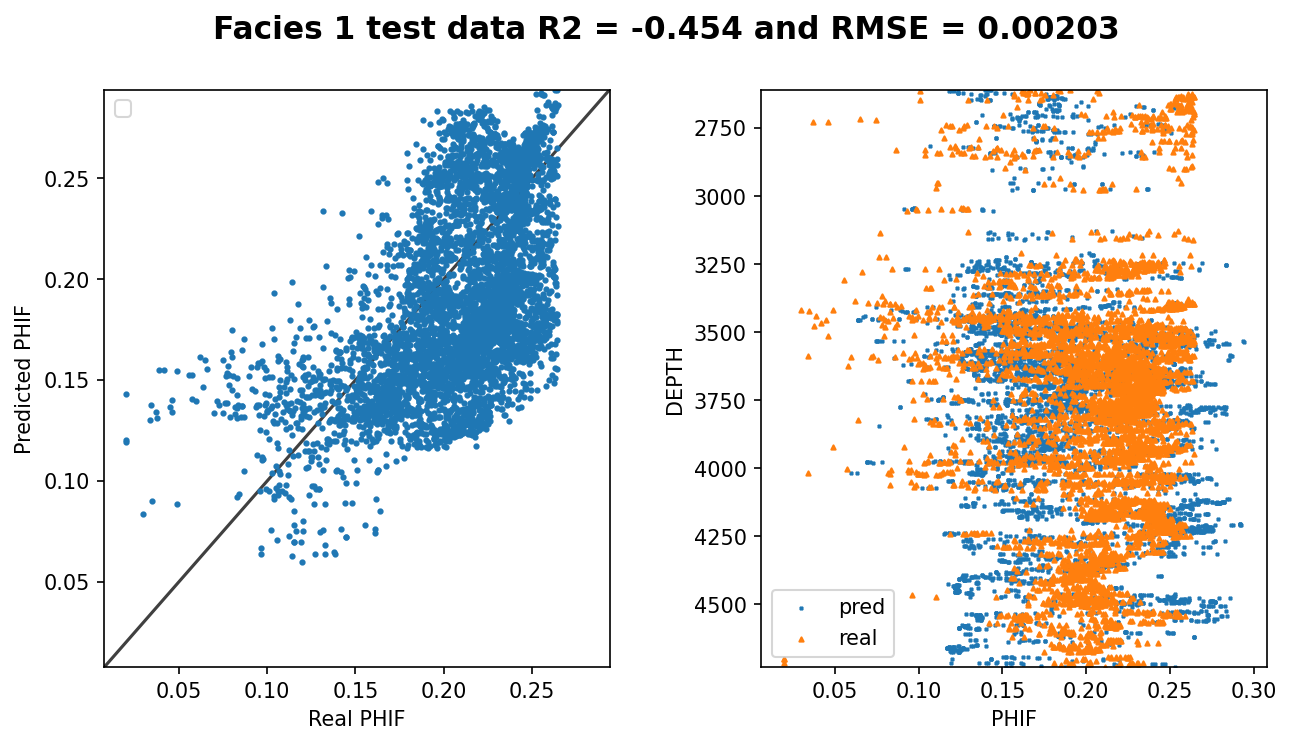

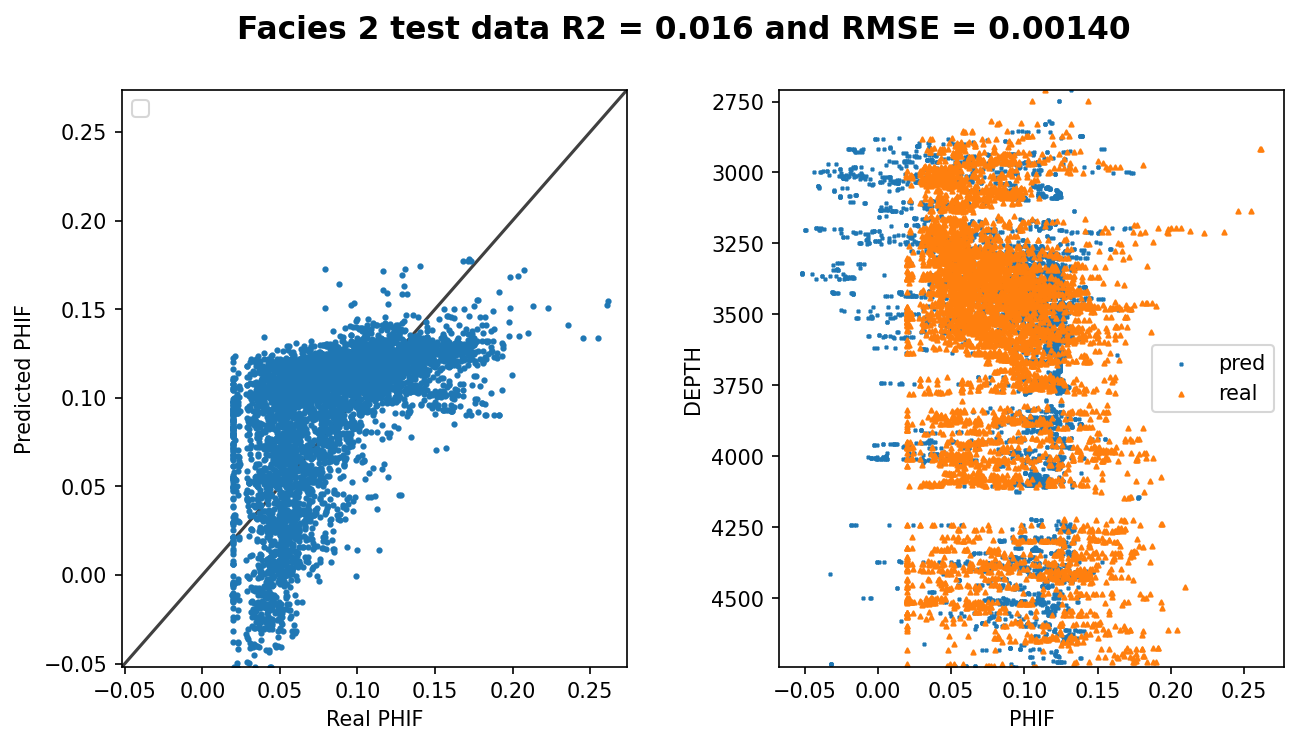

In [37]:
# Split dataset into target and attributes
# arrays for saving predictions
Y_pred_POR=np.zeros(POR_blind.shape[0])
name='PHIF'
for i in POR['Facies'].unique():
    POR_split=POR[POR.Facies.values==i].copy()
    target = POR_split[['DEPTH', 'PHIF']]
    target.set_index('DEPTH', inplace=True)
    attributes = POR_split.drop(['WELL_NAME', 'DEPTH', 'PHIF', 'Facies'], axis = 1)
    attributes = apply_filter(attributes, name=name)
    
    model, Prescale, results = model_predict(attributes,target,'Facies %s' % str(i+1), name=name)
    print(model.best_params_)
    
    #BLIND WELL TEST
    POR_blind_split=POR_blind[POR_blind.Facies.values==i].copy()
    Y_blind = POR_blind_split[['DEPTH', 'PHIF']]
    Y_blind.set_index('DEPTH', inplace=True)
    X_blind = POR_blind_split.drop(['WELL_NAME', 'DEPTH', 'PHIF', 'Facies'], axis = 1)
    X_blind = apply_filter(X_blind, name=name)
    

    # save the prediction
    Y_blind_pred = model.predict(Prescale.transform(X_blind))
    Y_pred_POR[POR_blind.Facies.values==i]=Y_blind_pred
    
Y_test_POR=POR_blind['PHIF'].values

Text(0.5, 1.0, 'R2 = 0.535 and RMSE = 0.00197')

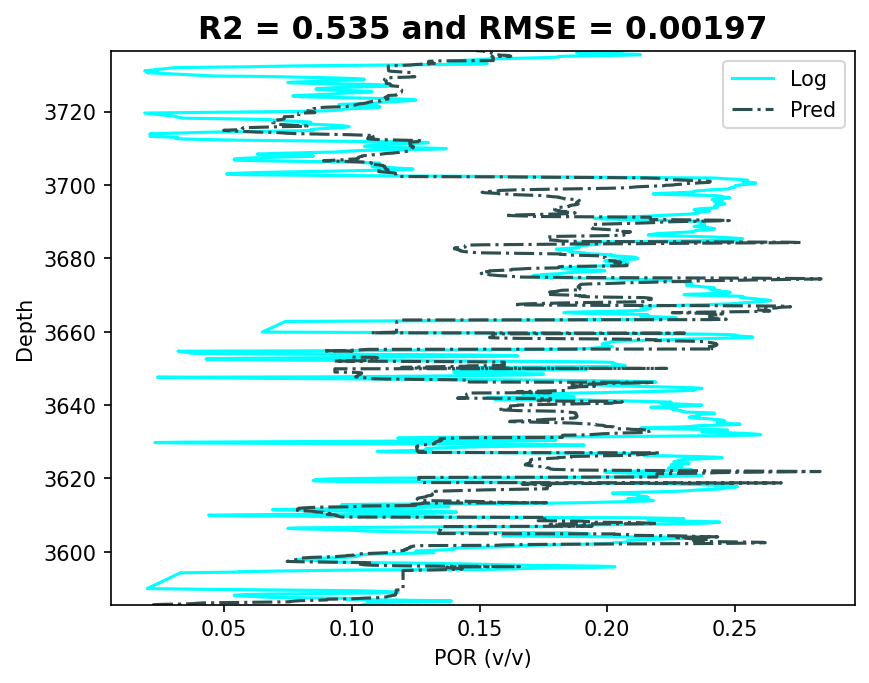

In [38]:
#test the accuracy
mse = mean_squared_error(Y_test_POR, Y_pred_POR)
r2 = r2_score(Y_test_POR, Y_pred_POR)

plt.plot(Y_test_POR, POR_blind.DEPTH, c='cyan')
plt.plot(Y_pred_POR, POR_blind.DEPTH, c='darkslategrey', linestyle='-.')
plt.xlabel('POR (v/v)')
#plt.xlim(0,1) 
plt.ylim(np.min(POR_blind.DEPTH),np.max(POR_blind.DEPTH)) 
plt.ylabel('Depth')
plt.legend(['Log', 'Pred'], loc=0)
plt.title('R2 = {:.3f} and RMSE = {:.5f}'.format(r2, mse), weight='bold', fontsize=15)